# Weighted Network of Two Different Types of Coral Using SparCC Similarity As Input
## Quinn Lab
### by: Warren Sink

This is a record of an analysis I made on the dataset I received from Dr.Quinn. The  

The coral dataset is composed of 50 paired coral samples (100 total observations / rows) and is split 40/60 among the two types of coral represented here: one type represented by tens (e.g. 11, 12, etc.) and the other represented by hundreds (e.g. 111, 112, etc.). 

There are 15 columns of metadata and 3560 columns of untargeted metabolomic count data. I have been told that the coral exhibit different bleaching rates (one type of coral is more robust against bleaching than the other) under stressful environmental conditions (e.g. increase in temperature of the water over a long duration of time). I was never told which coral is more robust, although, with a preliminary analysis of the data and, specifically, the Bleaching History Phenotype, we should be able to readily see which type of coral is less likely to bleach.

Furthermore, once the adaptive coral identified I can go on and compare the metabolomes of the more robust coral to the less robust coral under a gradient of Temperature.Treatments, which should demonstrate competitive advantages the more robust coral has on the less robust. 

The code chunk below loads libraries I will use throughout, like tidyverse, and for specific chunks only, like for PCA and UMAP or for printing out tables; I also load the data and make a new dataframe, which has sum-(or, library-) normalized metabolite values.

In [ ]:
#for suppressing warnings
options(warn=-1)
#for data manipulation
library(tidyverse)
#for pca analysis
library(factoextra)
#for UMAP
library(umap)
#for printing tables
library(knitr)
library(kableExtra)
library(IRdisplay)

#reading in coral data
coral_data <- 
  read.table(file = "./data/T1T2_coral_buckettable.csv", header = TRUE, sep = ",") %>%
  mutate(Colony = as.character(Colony))

#sum-normalization
coral_data_norm <-
  coral_data[,15:ncol(coral_data)] %>%
  select_if(~ !any(is.na(.))) %>%
  mutate(across(where(is.double), ~ .x / Sum)) %>%
  cbind(coral_data[,1:14], .) %>%
  as.data.frame() 

## Does the Bleaching History Phenotype Make Sense?

The Bleaching History Phenotype is a metadata variable containing one of two levels per observation (for a coral at a timepoint): "Bleached" or "Not Bleached." Later on, we will want to model the metabolome using a correlation network and correlate it with the Bleaching History phenotype (e.g. the increase of certain metabolites correlate with a certain coral type, which is robust to bleaching, at TimePoint 2). In this experiment, the treatment levels are in the Temperature.Treatment metadata variable and may be either Control, Constant, Pulse, Pulse Increase, and Pulse High.

Before proceeding to analyze the metabolomic data itself, I have run McNemar's test on the paired samples to detect whether there occurs differential bleaching according to stages, T1 and T2. McNemar's test is a $\chi^2$ test specific for paired data. To visualize, a $2 * 2$ contingency table is created whereby the quadrants refer to the presence of a trait with both instances of paired data, in one instance and not the other, or in neither instance. In this experiment, the Bleaching History Phenotype is recorded at stages T1 and T2; so, to translate, the quadrants of the $2 * 2$ contingency table represent when a coral is bleached at T1 and T2, when only at T1 or only at T2, or neither.

In [3]:
#II and III
countIIandIII <- 
  coral_data_norm %>%
  select(Colony, TimePoint, Temperature.treatment, BleachingHistoryPhenotype) %>%
  mutate(Colony_id = case_when(Temperature.treatment == "Control" ~ paste0(Colony, "_control"),
                               Temperature.treatment == "Constant" ~ paste0(Colony, "_constant"),
                               Temperature.treatment == "Pulse Increase" ~ paste0(Colony, "_pulseIncrease"),
                               Temperature.treatment == "Pulse" ~ paste0(Colony, "_pulse"),
                               Temperature.treatment == "Pulse High" ~ paste0(Colony, "_pulseHigh"))) %>%
  select(Colony_id, TimePoint, BleachingHistoryPhenotype) %>%
  group_by(Colony_id) %>%
  pivot_wider(names_from = TimePoint, values_from = BleachingHistoryPhenotype) %>%
  ungroup() %>%
  mutate(bothT1T2 = ifelse(T1 == "Bleached" & T2 == "Bleached", 1, 0), 
         justT1 = ifelse(T1 == "Bleached" & T2 == "Not Bleached", 1, 0),
         justT2 = ifelse(T1 == "Not Bleached" & T2 == "Bleached", 1, 0),
         bothNot = ifelse(T1 == "Not Bleached" & T2 == "Not Bleached", 1, 0)) %>%
  select(bothT1T2, justT1, justT2, bothNot) %>%
  colSums() %>%
  t() %>%
  as.data.frame()

topContig <- cbind(countIIandIII$bothT1T2, countIIandIII$justT2)
bottomContig <- cbind(countIIandIII$justT1, countIIandIII$bothNot)
contig_II_III <- rbind(topContig, bottomContig) %>% as.matrix()
colnames(contig_II_III) <- c("Yes","No") 
rownames(contig_II_III) <- c("Yes","No")

#contig table - input to mcnemar test
contig_II_III %>%
  kbl(format = "html", caption = "Joint Bleaching Phenotype Table") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()

Joint Bleaching Phenotype Table 
 
 
 
 Yes 
 No 
 
 
 
 
 Yes 
 25 
 0 
 
 
 No 
 0 
 25

Oddly, there are no coral, which were not bleached at TimePoint 1 and became bleached at TimePoint 2. We expect the reverse to not happen; otherwise, would indicate a transcribing error. We can perform the McNemar test, but the fact there are no observations of "switching" presents a problem.

The null hypothesis is for there to be no difference in bleaching from stages T1 to T2.

The alternative hypothesis is there is a difference in bleaching from stages T1 to T2. 

Alpha is set to 0.05.

In [4]:
mcnemar.test(contig_II_III)


	McNemar's Chi-squared test

data:  contig_II_III
McNemar's chi-squared = NaN, df = 1, p-value = NA


We cannot generate a p-value with the data, because the data does not meet the assumption of there being "switching" from no bleaching to bleaching (one of the yes/no contingencies). Neither can we calculate a test statistic. The McNemar test is DOA. We fail to reject the null hypothesis; there is insufficient evidence to conclude bleaching occurs from stage T1 to stage T2. Not only will there be a problem for correlating bleaching to the metabolomic network, the result of the test suggests the there is no discernible effect produced by the different types of treatments (Control, Pulse, etc).

Something that I have taken for granted with the McNemar test are the different treatments for the observations, which we would have had to separate the data by if there were any demonstrable effect seen.

We can further visualize the lack of "switching" by separating observations based on treatment. 

In [5]:
temp_coral_contig <-
  coral_data_norm %>%
  select(Colony, TimePoint, Temperature.treatment, BleachingHistoryPhenotype) %>%
  pivot_wider(names_from = TimePoint, values_from = BleachingHistoryPhenotype) %>%
  mutate(bothT1T2 = ifelse(T1 == "Bleached" & T2 == "Bleached", 1, 0), 
         justT1 = ifelse(T1 == "Bleached" & T2 == "Not Bleached", 1, 0),
         justT2 = ifelse(T1 == "Not Bleached" & T2 == "Bleached", 1, 0),
         bothNot = ifelse(T1 == "Not Bleached" & T2 == "Not Bleached", 1, 0)) %>%
  select(Temperature.treatment, bothT1T2, justT1, justT2, bothNot) %>%
  group_split(Temperature.treatment) 

temp_df <- data.frame() 
for (i in 1:length(temp_coral_contig)){
  
  TempTreatment <- unique(temp_coral_contig[[i]][1])[[1]]
  temp_df <- 
    colSums(temp_coral_contig[[i]][2:5]) %>%
    t() %>%
    as.data.frame()
    assign(TempTreatment, temp_df)
  
}

#table showing count of bleaching by treatment
alternate_contig_table <- rbind(Control, Constant, Pulse, `Pulse High`, `Pulse Increase`)
rownames(alternate_contig_table) <- c("Control","Constant","Pulse","Pulse High","Pulse Increase")
alternate_contig_table %>%
  kbl(format = "html", caption = "Joint Bleaching Phenotype Table") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()

Joint Bleaching Phenotype Table 
 
 
 
 bothT1T2 
 justT1 
 justT2 
 bothNot 
 
 
 
 
 Control 
 5 
 0 
 0 
 5 
 
 
 Constant 
 5 
 0 
 0 
 5 
 
 
 Pulse 
 5 
 0 
 0 
 5 
 
 
 Pulse High 
 5 
 0 
 0 
 5 
 
 
 Pulse Increase 
 5 
 0 
 0 
 5

According to the contingency table or the test result, there are no coral which have variation in the Bleaching History Phenotype variable from stages T1 and T2 i.e. there is no difference between coral at T1 and the same coral at T2. This is obviously problematic for correlating the bleaching with the metabolomic network later on. It seems to point to an error in the Bleaching History Phenotype data or in my interpretation of their values. Maybe all of T1-associated values are supposed to be Not Bleached, no matter the T2 values? __Need feedback__.

Moreover, if we look at the number of bleached coral by coral type, I see the same spaced-out counts.

In [46]:
coral_data %>% 
    mutate(`Coral Type` = ifelse(str_length(Colony) > 2, "III", "II")) %>%
    group_by(`Coral Type`) %>%
    count(BleachingHistoryPhenotype) %>%
    kbl(format = "html", caption = "Bleaching Phenotype by Coral-Type") %>%
    kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
    as.character() %>%
    display_html()

Bleaching Phenotype by Coral-Type 
 
 
 Coral Type 
 BleachingHistoryPhenotype 
 n 
 
 
 
 
 II 
 Bleached 
 20 
 
 
 II 
 Not Bleached 
 20 
 
 
 III 
 Bleached 
 30 
 
 
 III 
 Not Bleached 
 30

The rest of this Jupyter Notebook, although maybe slightly in vain, is how I believe I should proceed if the Bleaching History Phenotype were comprehensible i.e. had variation from T1 to T2....

## Dimensional-Reduction Visualization of Metabolome

We can visualize the relationships between the observations by using dimensional reduction analysis with PCA and UMAP. For preparing the data, I perform the [isometric log transformation](https://link.springer.com/article/10.1023/A:1023818214614) (```ilr```), which is similar to the centered log ratio transformation (```clr```). [There is a certain amount of online discussion about how to transform compositional data prior to PCA](https://stats.stackexchange.com/questions/305965/can-i-use-the-clr-centered-log-ratio-transformation-to-prepare-data-for-pca). 

```ilr``` and ```clr``` transformed data are similar, but serve different purposes in our case because 1) the ```ilr``` transformed data meets the Aitchinsonian criteria for compositional data, while ```clr``` doesn't meet the expectation of subcompositional coherence; and 2) the ```ilr``` transformed data variables are $p - 1$ where $p$ is the number of variables in the original dataset (I do not know a way of meaningfully interpreting the transformed variables as representative of a singular particular metabolite or another), while ```clr``` retains the variables in name. Most importantly, with ```ilr```, we have data, which has been transformed to a euclidean space, where linear methods may now be performed on the data.

In [6]:
metadata <- 
  coral_data %>%
  select(Colony, TimePoint, Temperature.treatment, BleachingHistoryPhenotype) %>%
  mutate(Colony_binary = ifelse(str_length(as.character(Colony)) == 3, "1", "0")) %>%
  select(Colony, Colony_binary, TimePoint, Temperature.treatment, BleachingHistoryPhenotype)

coral_data_ilr <-
  coral_data[,16:ncol(coral_data)] %>%
  compositions::ilr(.)

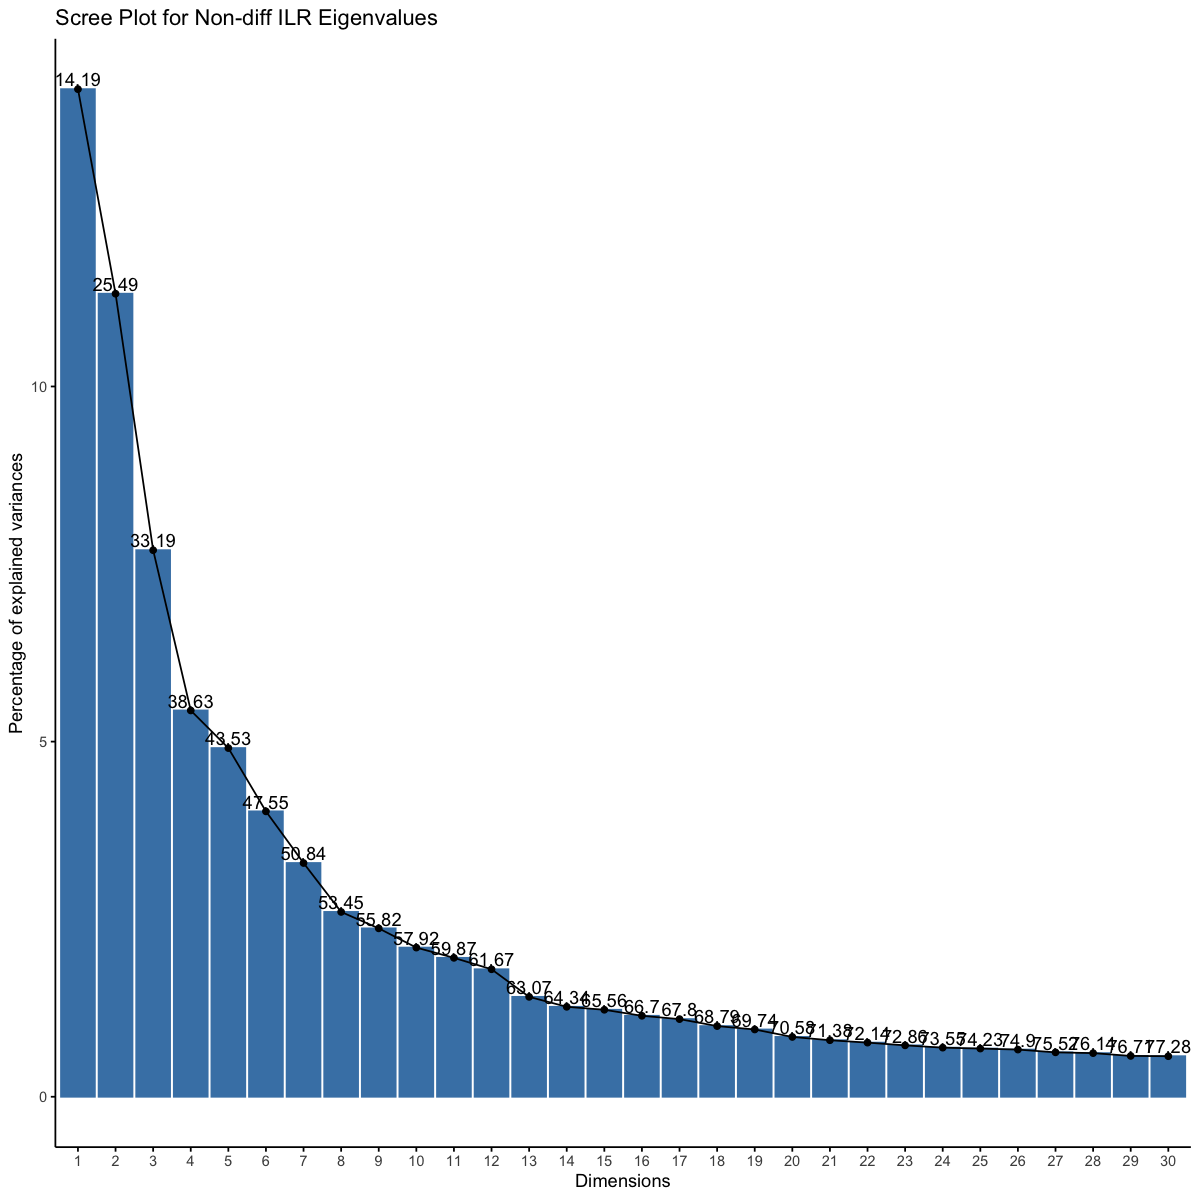

In [7]:
res.pca <- coral_data_ilr %>% prcomp(., center = TRUE, scale. = TRUE) 

eigenvalues <- get_eig(res.pca)
pc1_pev <- round(eigenvalues[1,which(names(eigenvalues) %in% c("variance.percent"))],3)
pc2_pev <- round(eigenvalues[2,which(names(eigenvalues) %in% c("variance.percent"))],3)

eigenvalues.cumulative.variance.percent <- 
  eigenvalues %>% 
  select(cumulative.variance.percent) %>% 
  head(30) %>%
  round(2)

scree <-
  fviz_eig(res.pca, ggtheme = theme_classic(), title = "Scree Plot for Non-diff ILR Eigenvalues", ncp = 30) +
  geom_text(aes(label=eigenvalues.cumulative.variance.percent[,1]), position=position_dodge(width=0.9), vjust=-0.25)

PCs_andMetadata <- 
  res.pca[["x"]] %>%
  as.data.frame() %>%
  cbind(metadata, .)

Biplot_Colony <-
  PCs_andMetadata %>%
  ggplot(aes(x = PC1, y = PC2, color = Colony, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = PC1, y = PC2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  scale_color_discrete(guide = "none") +
  theme_minimal() +
  labs(x=bquote("PC1 (" ~ .(pc1_pev) ~ "%)"), y=bquote("PC2 (" ~ .(pc2_pev) ~ "%)"))

Biplot_ColonyBinary <-
  PCs_andMetadata %>%
  ggplot(aes(x = PC1, y = PC2, color = Colony_binary, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = PC1, y = PC2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  scale_color_discrete(guide = "none") +
  theme_minimal() +
  labs(x=bquote("PC1 (" ~ .(pc1_pev) ~ "%)"), y=bquote("PC2 (" ~ .(pc2_pev) ~ "%)"))

Biplot_TimePoint <-
  PCs_andMetadata %>%
  ggplot(aes(x = PC1, y = PC2, color = TimePoint, shape = Colony_binary)) +
  geom_point(size = 5) +
  #ggrepel::geom_text_repel(aes(x = PC1, y = PC2, label = Colony), max.overlaps = 20) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x=bquote("PC1 (" ~ .(pc1_pev) ~ "%)"), y=bquote("PC2 (" ~ .(pc2_pev) ~ "%)"))

Biplot_Temperature <-
  PCs_andMetadata %>%
  ggplot(aes(x = PC1, y = PC2, color = Temperature.treatment, shape = Colony_binary)) +
  geom_point(size = 5) +
  #ggrepel::geom_text_repel(aes(x = PC1, y = PC2, label = Colony), max.overlaps = 20) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x=bquote("PC1 (" ~ .(pc1_pev) ~ "%)"), y=bquote("PC2 (" ~ .(pc2_pev) ~ "%)"))

Biplot_Bleaching <-
  PCs_andMetadata %>%
  ggplot(aes(x = PC1, y = PC2, color = BleachingHistoryPhenotype, shape = Colony_binary)) +
  geom_point(size = 5) +
  #ggrepel::geom_text_repel(aes(x = PC1, y = PC2, label = Colony), max.overlaps = 20) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x=bquote("PC1 (" ~ .(pc1_pev) ~ "%)"), y=bquote("PC2 (" ~ .(pc2_pev) ~ "%)"))

options(repr.plot.width = 10, repr.plot.height = 10)
scree

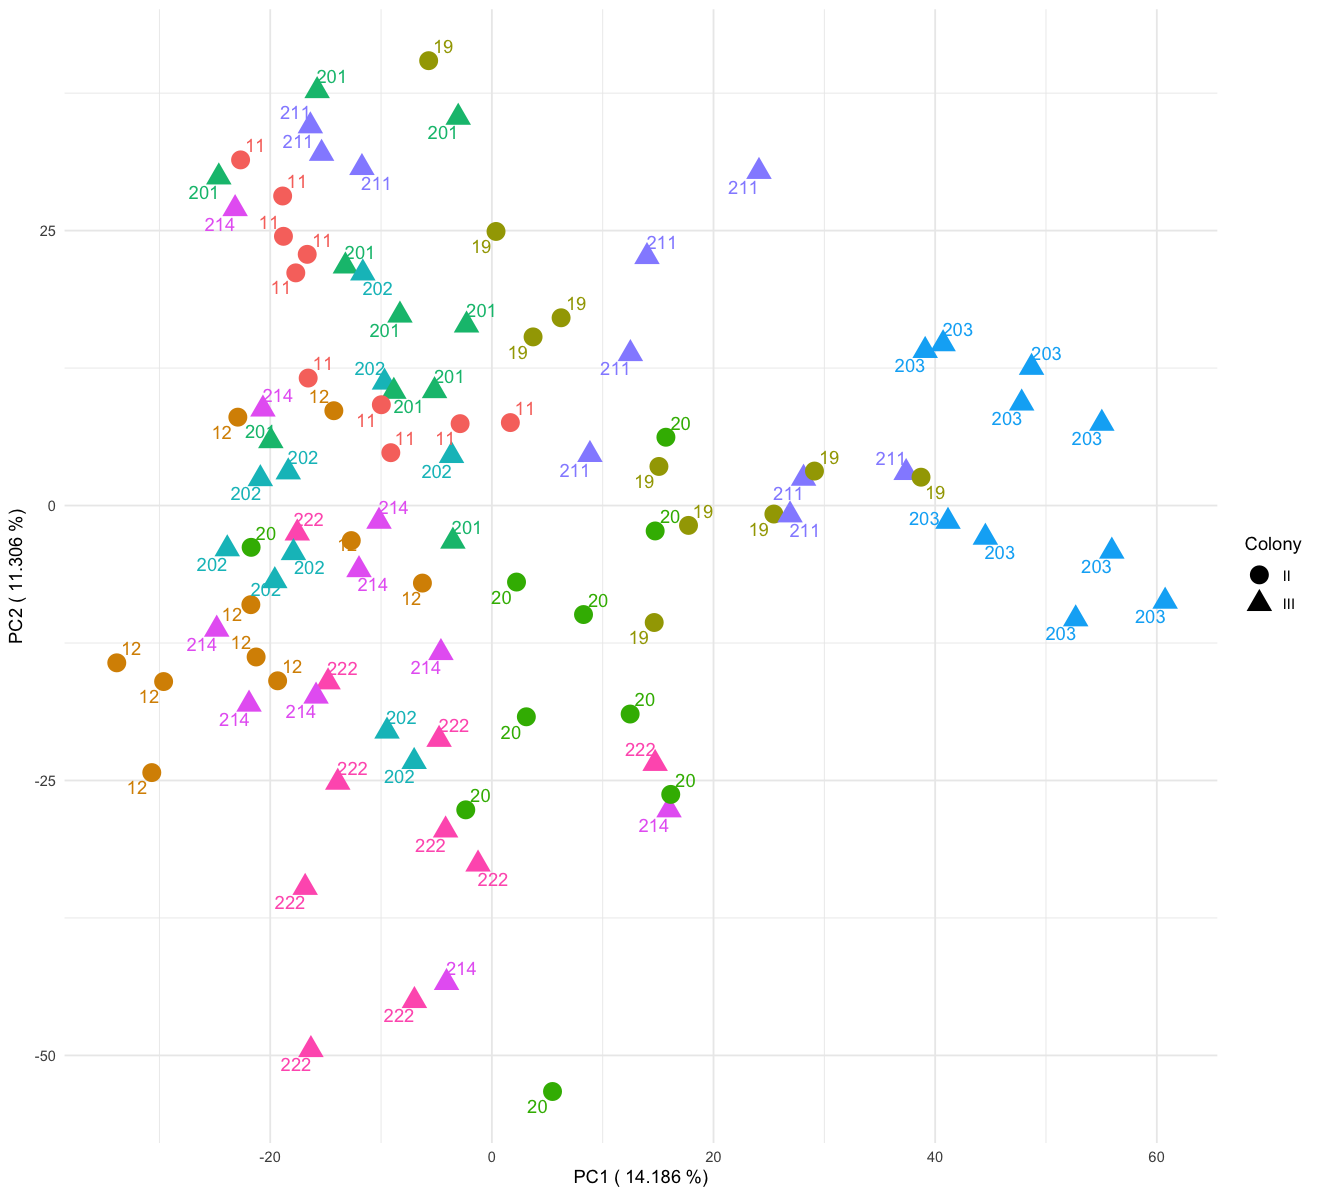

In [8]:
options(repr.plot.width = 11, repr.plot.height = 10)
Biplot_Colony

In [9]:
options(repr.plot.width = 11, repr.plot.height = 10)
Biplot_ColonyBinary

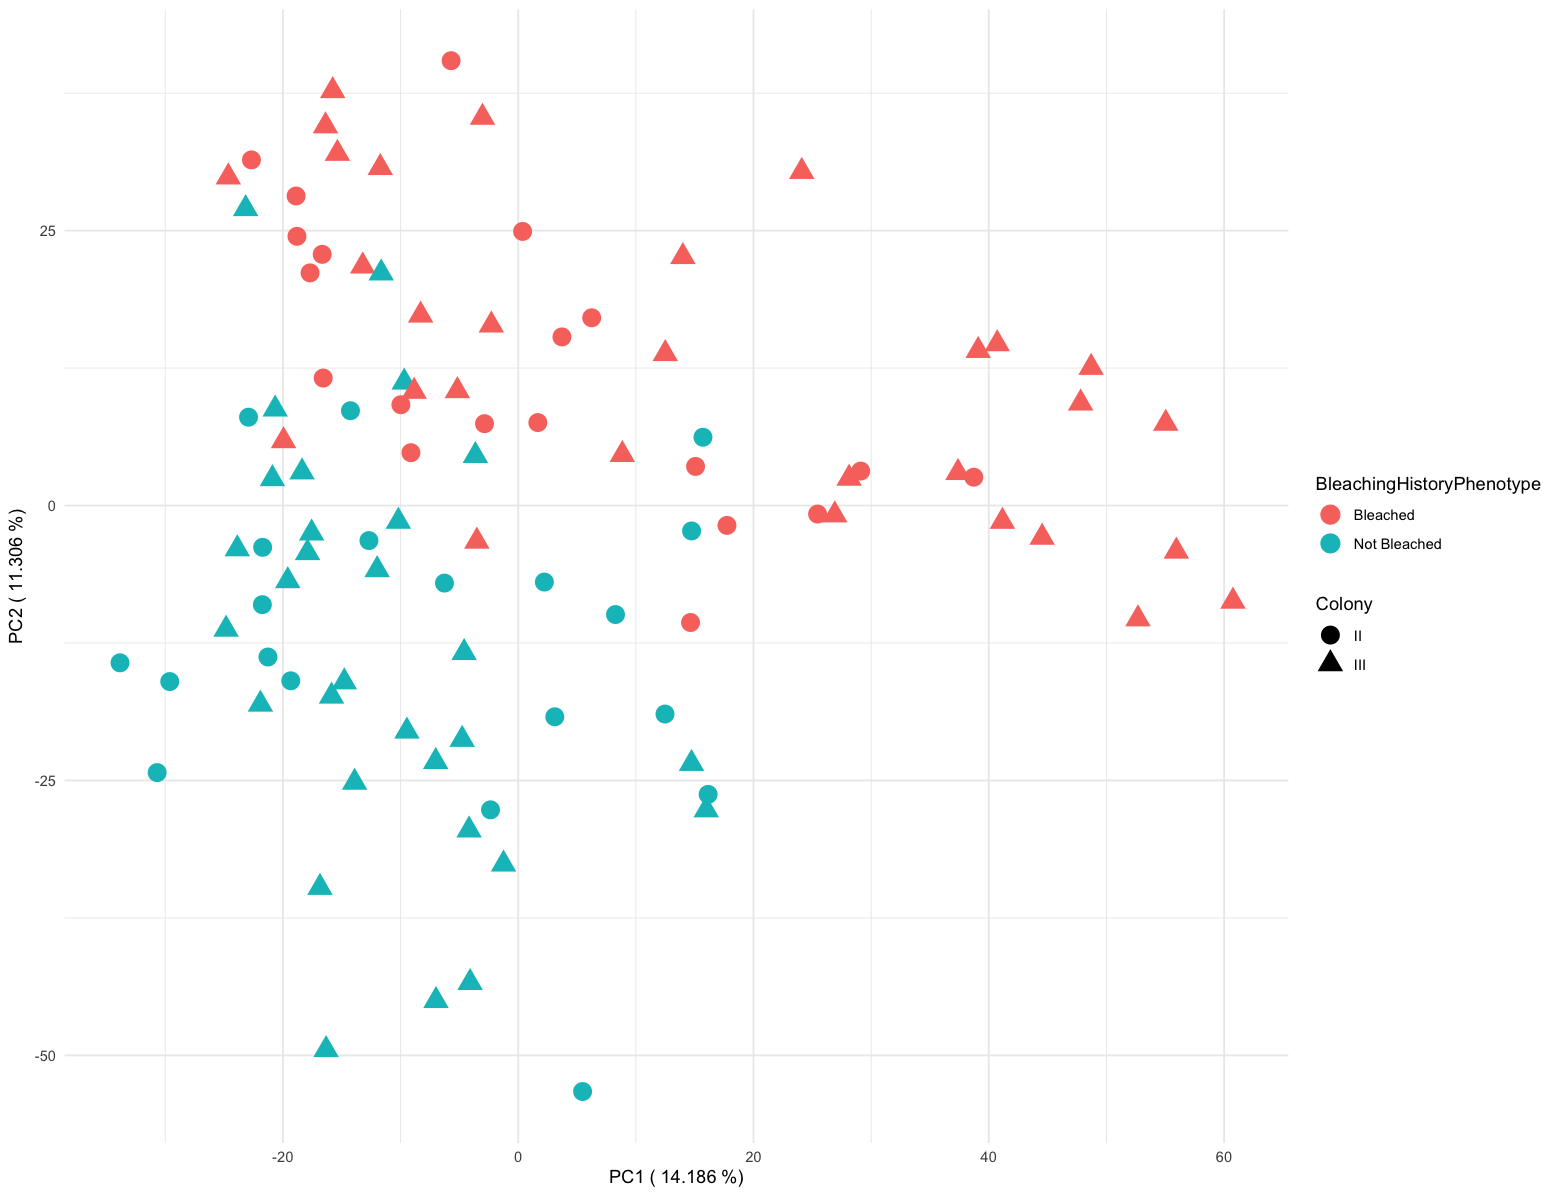

In [10]:
options(repr.plot.width = 13, repr.plot.height = 10)
Biplot_Bleaching

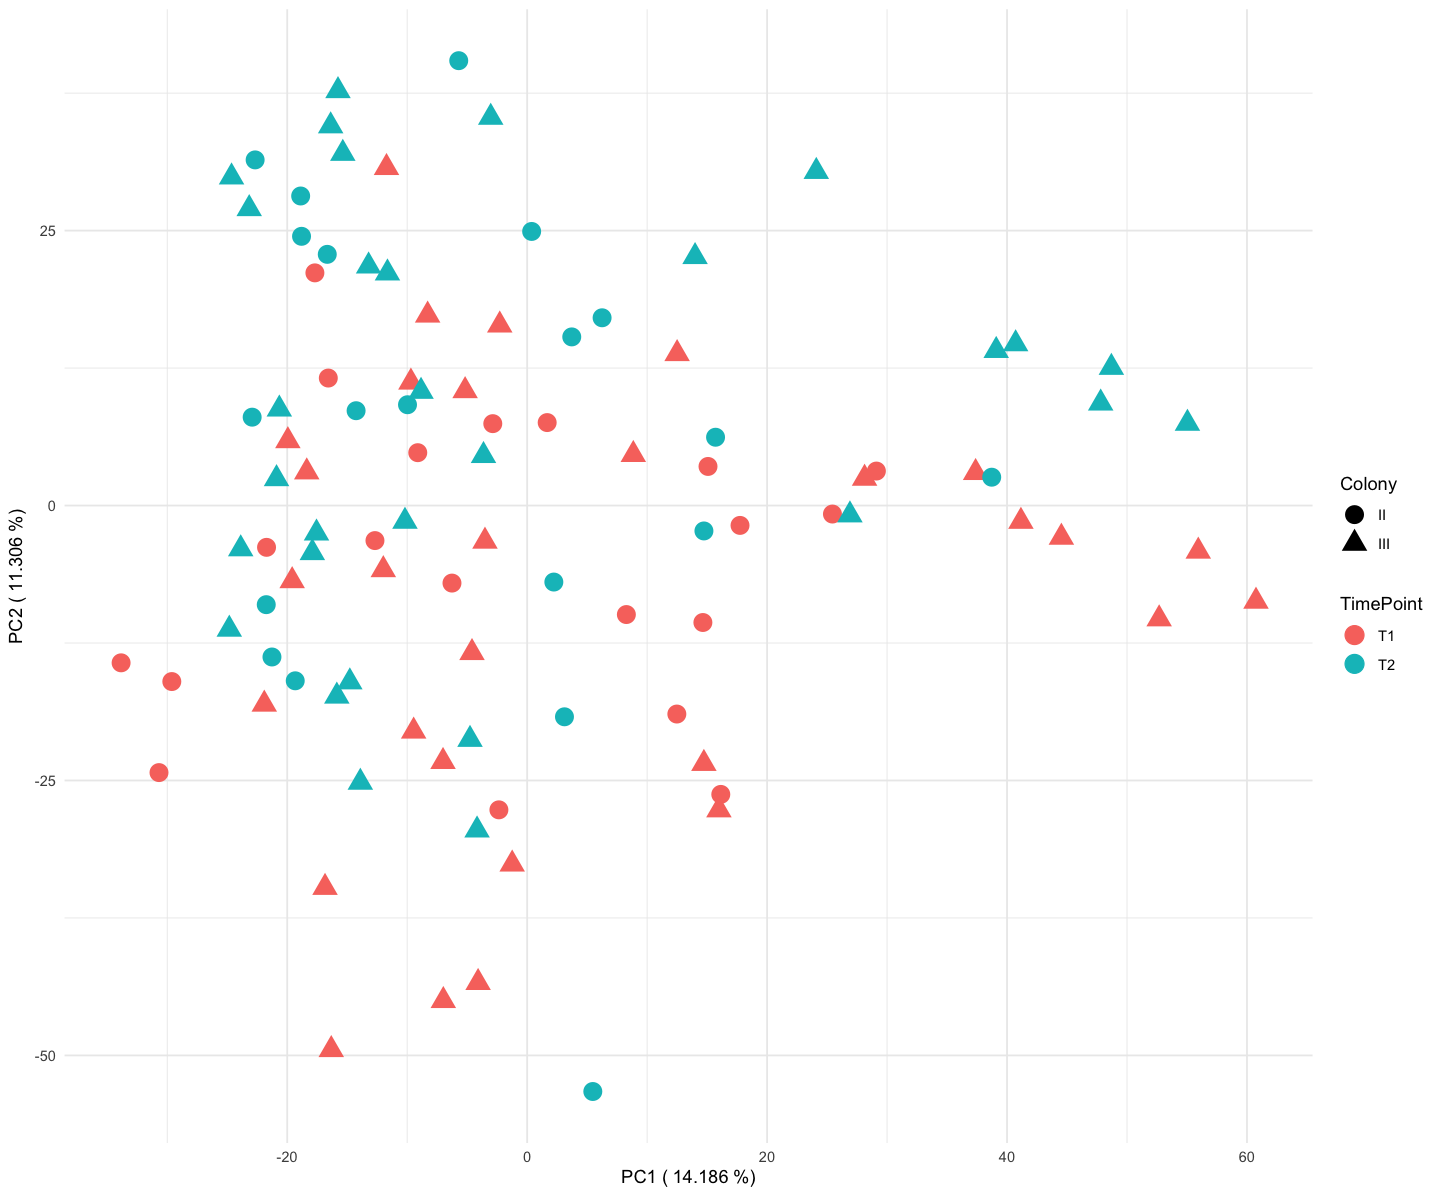

In [11]:
options(repr.plot.width = 12, repr.plot.height = 10)
Biplot_TimePoint

In [12]:
options(repr.plot.width = 13, repr.plot.height = 10)
Biplot_Temperature

By the first two PCs (~25% of the explained variance), we see the best separation of the metabolomes by the Bleaching History Phenotype, which visually means the the corals' global variation is best explained by the presence of bleaching; furthermore, they also visually separate well based on TimePoint, which demonstrates the Treatment has had some overall effect on each individual coral; however, the pattern of treatment type is unclear in the data, pointing toward a lack of influence; and although observations tend to cluster with members from the same colony (11s with other 11s, etc.), there does not seems to be a clear pattern with respect to the coral type (i.e. IIs do not seem to cluster with other IIs, IIIs with other IIIs). 

These observations with the biplot mostly translate to the UMAPs of the metabolome. Oftentimes, with t-SNE, the dataset is reduced to PCs; then, fed into the t-SNE method. With UMAP,  Furthermore, I have chosen to use the ```ilr``` transformed data, instead of the raw or sum-normalized data, because of the reason stated before: they take into account the compositional nature of the metabolomic data by transforming the count-type data to one where linear-type methods may be performed, like PCA. Losing the biological meaningfulness of the variables is not as nearly bad when we are not looking to understand which variables are driving the variation with the methods we want to perform on the transformed data. We only want to see if the global differences across the dataset are the result of Bleaching, TimePoint, Treatment, or Coral type. 

In [13]:
set.seed(123)
umap_coral_data_ilr <- umap::umap(as.data.frame(coral_data_ilr))

umap_andMetadata <- 
  umap_coral_data_ilr %>% 
  .$layout %>%
  as.data.frame() %>%
  cbind(metadata, .) 
umapColony <-
  umap_andMetadata %>%
  ggplot(aes(x = V1, y = V2, color = Colony, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = V1, y = V2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  scale_color_discrete(guide = "none") +
  theme_minimal() +
  labs(x="UMAP dim1", y="UMAP dim2")
umapColonyBinary <- 
  umap_andMetadata %>%
  ggplot(aes(x = V1, y = V2, color = Colony_binary, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = V1, y = V2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  scale_color_discrete(guide = "none") +
  theme_minimal() +
  labs(x="UMAP dim1", y="UMAP dim2")
umapTimpoint <-  
  umap_andMetadata %>%
  ggplot(aes(x = V1, y = V2, color = TimePoint, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = V1, y = V2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x="UMAP dim1", y="UMAP dim2")
umapTemperature <- 
  umap_andMetadata %>%
  ggplot(aes(x = V1, y = V2, color = Temperature.treatment, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = V1, y = V2, label = Colony)) +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x="UMAP dim1", y="UMAP dim2")
umapBleaching <-
  umap_andMetadata %>%
  ggplot(aes(x = V1, y = V2, color = BleachingHistoryPhenotype, shape = Colony_binary)) +
  geom_point(size = 5) +
  ggrepel::geom_text_repel(aes(x = V1, y = V2, label = Colony)) +
  scale_color_discrete(name = "Bleaching Phenotype") +
  scale_shape_discrete(name = "Colony", label = c("II","III")) +
  theme_minimal() +
  labs(x="UMAP dim1", y="UMAP dim2")

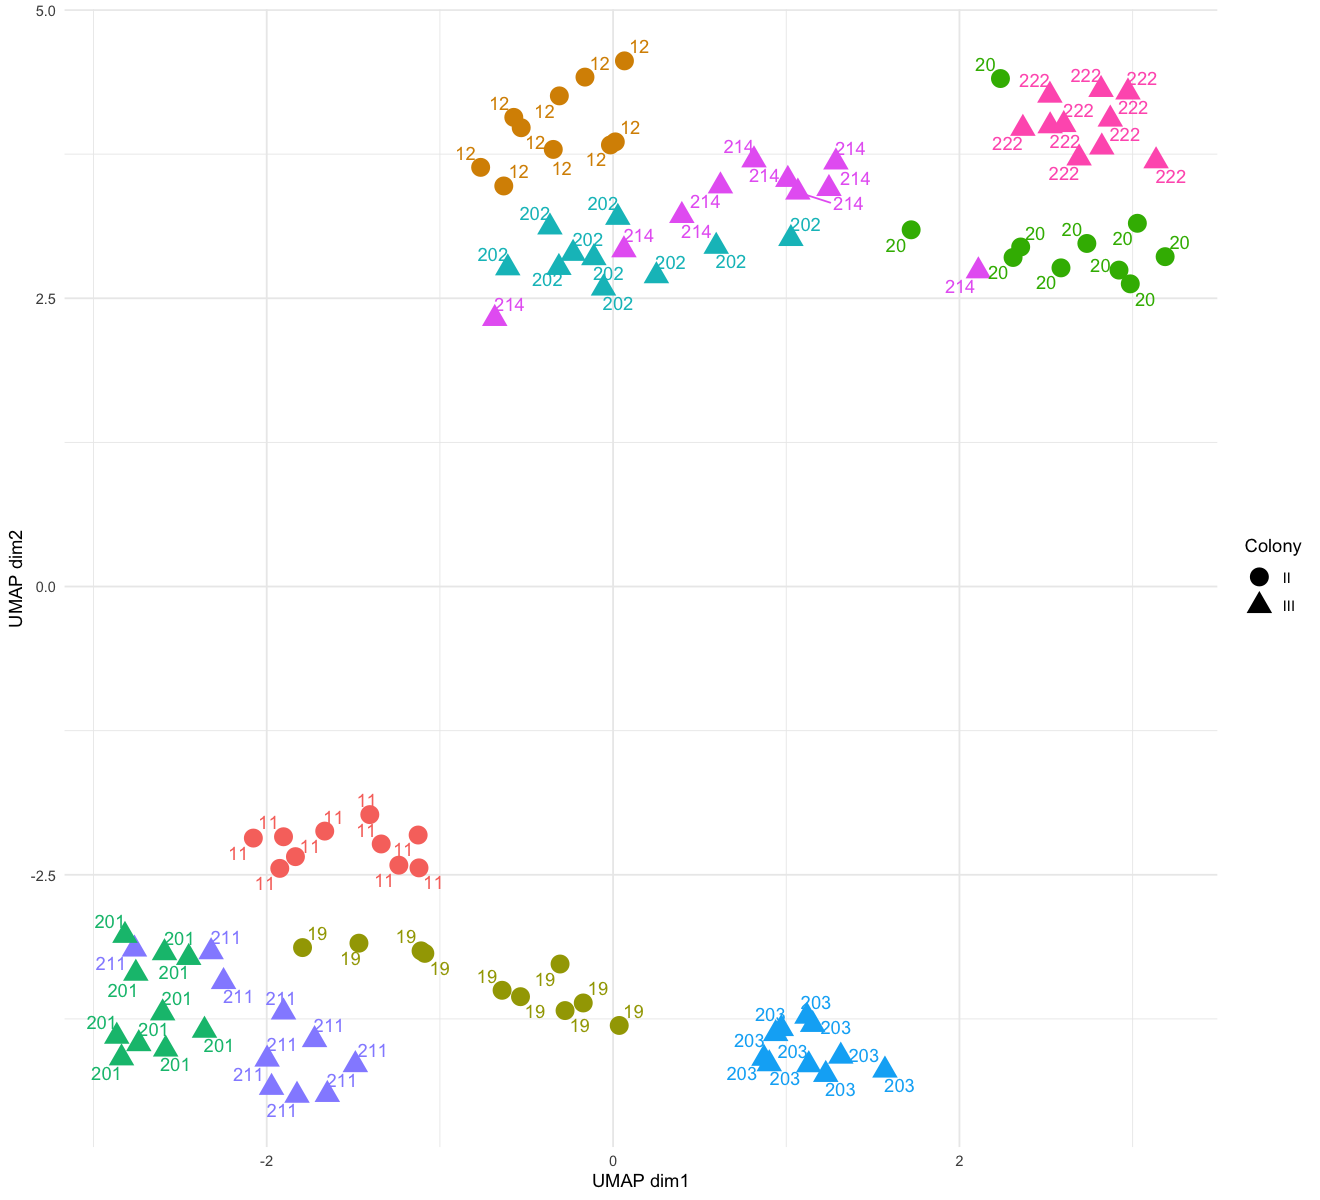

In [14]:
options(repr.plot.width = 11, repr.plot.height = 10)
umapColony

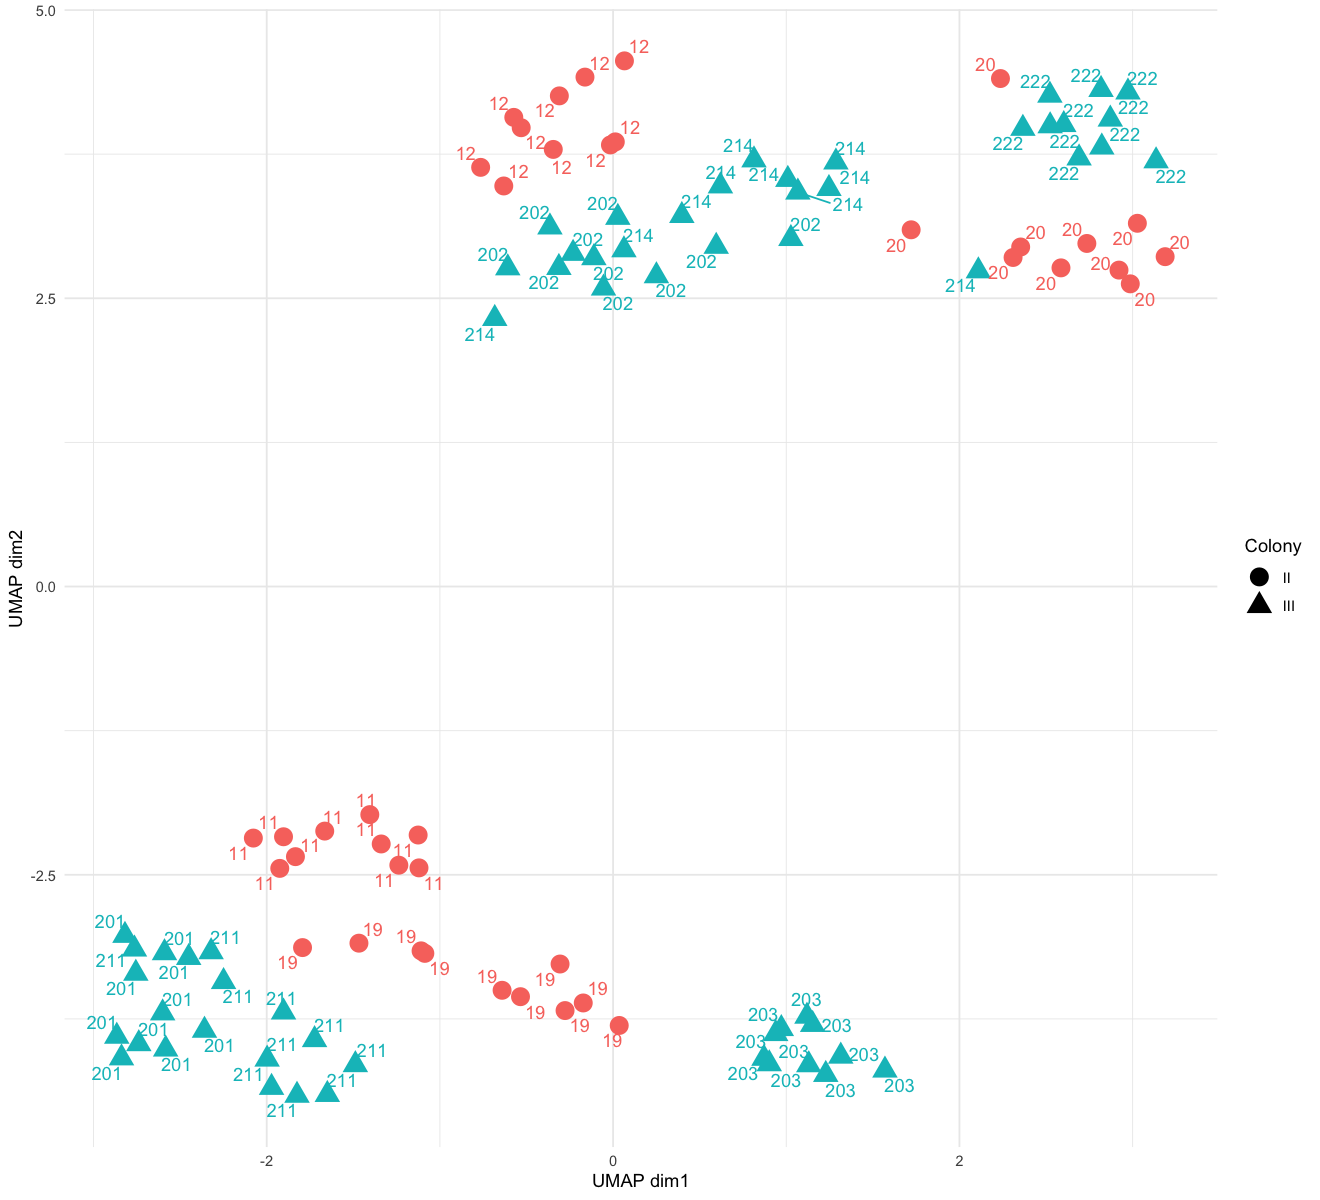

In [15]:
options(repr.plot.width = 11, repr.plot.height = 10)
umapColonyBinary

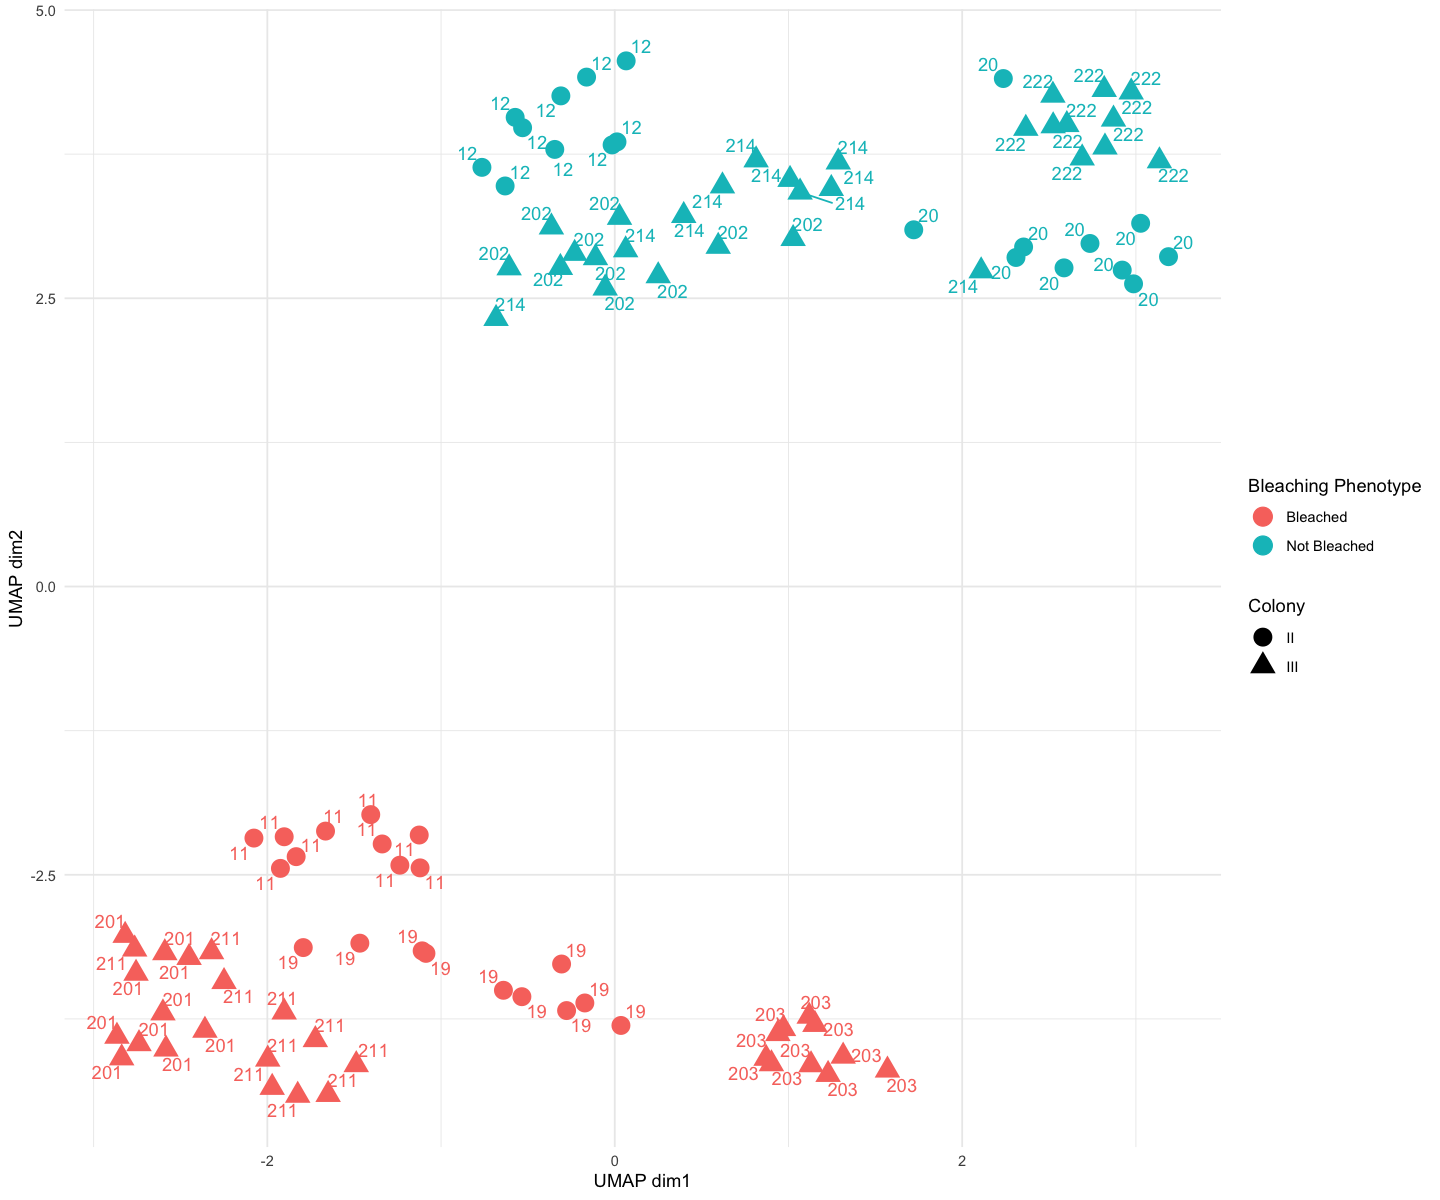

In [16]:
options(repr.plot.width = 12, repr.plot.height = 10)
umapBleaching

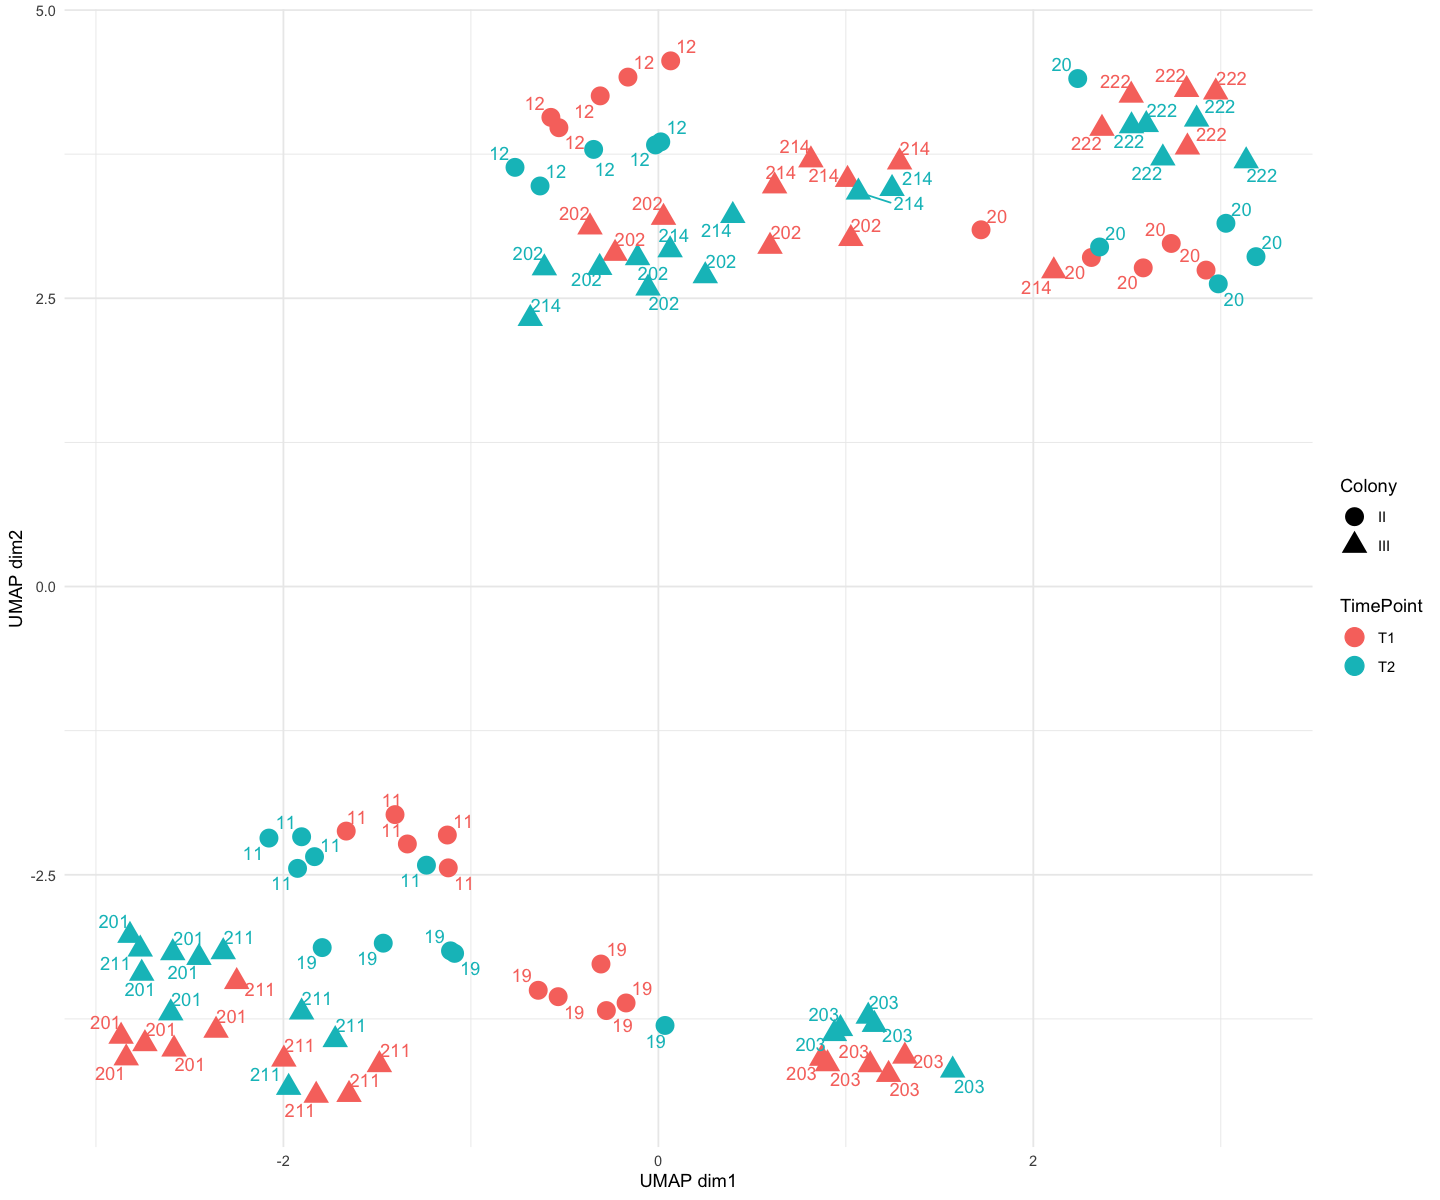

In [17]:
options(repr.plot.width = 12, repr.plot.height = 10)
umapTimpoint

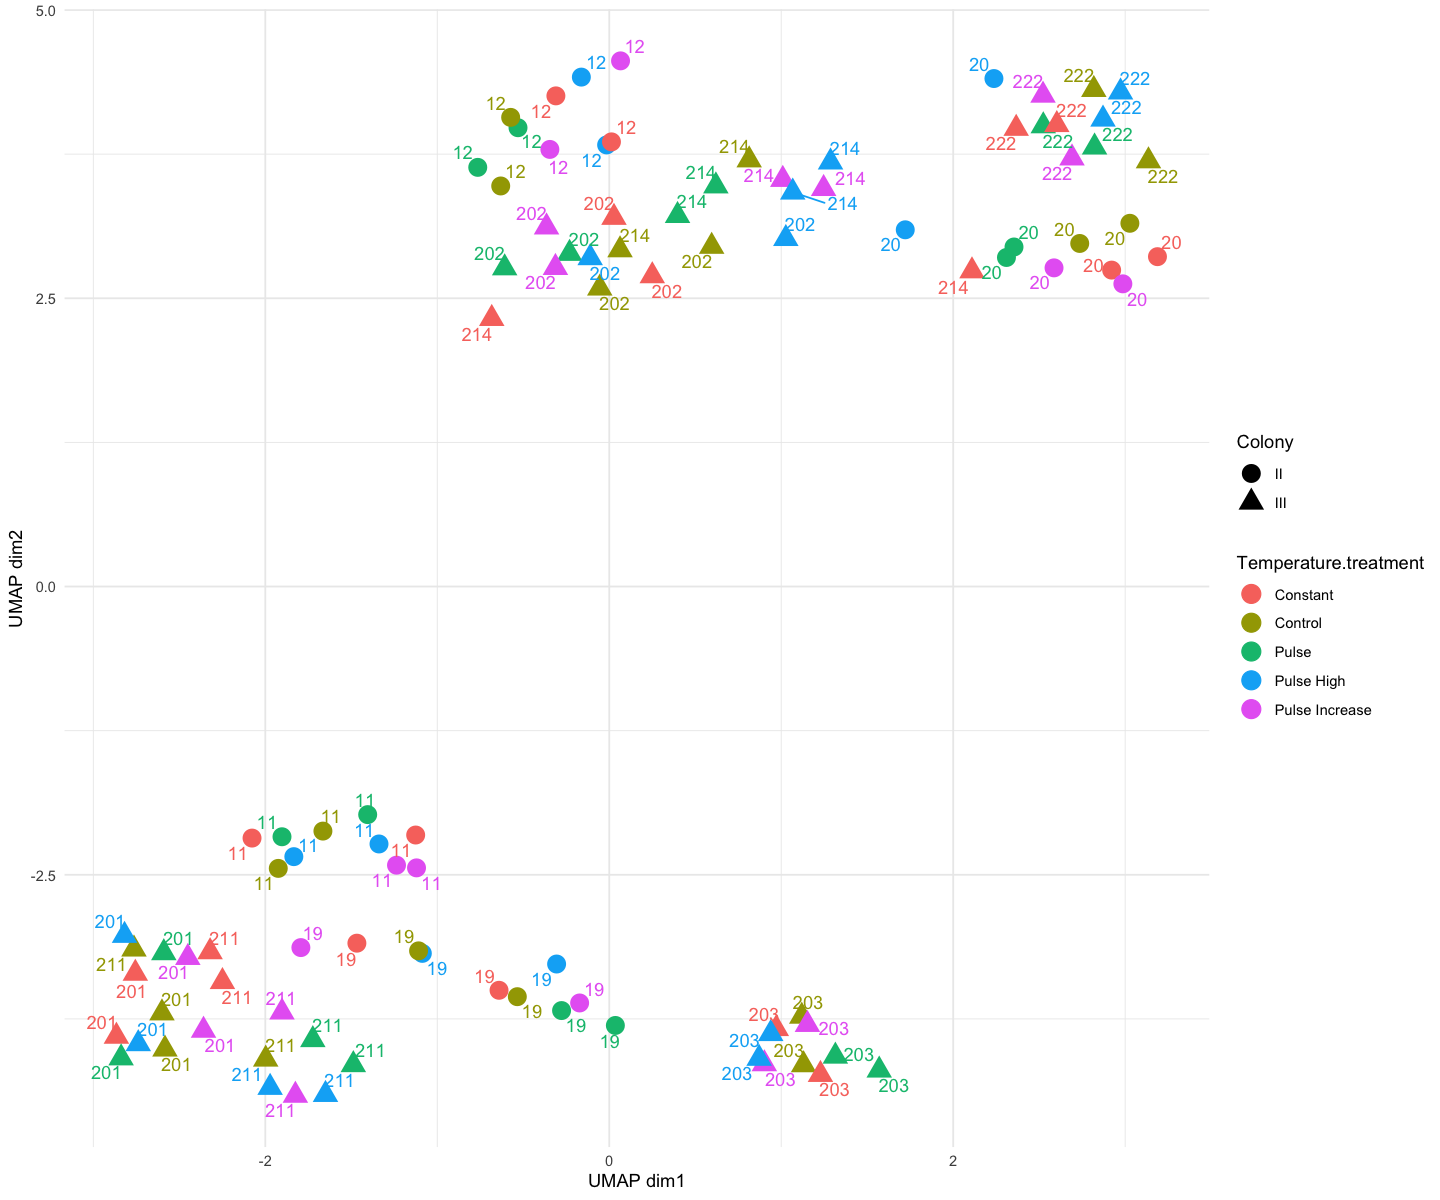

In [18]:
options(repr.plot.width = 12, repr.plot.height = 10)
umapTemperature

As seen in the PCAs, the Bleaching History Phenotype is able to separate the data into clusters very well; also, coral from the same colony co-localize; however, none of the other attributes are able to separate the data into clusters well i.e. visually, we can plainly see there is a high degree of mixing in the clusters, whether based on the type of coral (II or III), TimePoint, or Treatment.

Interestingly, as previously stated, neither the PCA or UMAP show any visual evidence of an effect on the global variation of the data by the Treament. From the control to the Pulse High and Pulse Increase, we see observations of all Treatment types in both clusters seen in the UMAP. Why this is, is beyond me, but it reflects the lack of a demonstrable effect on the metabolomes of the coral. Given the previous section's discussion of the McNemar test result (the lack of covariance between T1 and T2) and the results from UMAP, including the obvious separation of clusters based on Bleaching History Phenotype and the lack thereof by the Treatment, the Bleaching History Phenoype is likely real and not an error.

#### Conclusions

For segregating observations from the dataset...
- Colony seems to be more important than Coral.
- Bleaching History Phenotype is more important than TimePoint and Treatment.
- Bleaching History Phenotype is most important trait of all
Because of the obvious separation of clusters based on Bleaching History Phenotype and the lack thereof by the Treatment...
- The Bleaching History Phenoype is likely real and not an error


## Weighted Gene Correlation Network Analysis using sparCC

### Introduction

#### WGCNA

[Weighted Gene Correlation Network Analysis](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-559) (WGCNA) is an R package of techniques which uses Correlation, Weighted Adjacency, Topological Overlap Measure (TOM), Hierachical Clustering (HC), Tree Cutting (TC), and PCA to identify certain the first PC of modules identified by TCing the HC of the TOM. The overall idea is to form a network based on the similarity (i.e. correlation) matrix. It is most easily installed through CRAN.

<br>

![The WGCNA pipeline](img/WGCNA_pipeline.jpg)

</br>

1. Correlation - The first step in any WGCNA analysis is calculation of the similarity matrix, which is the correlation between each column of the data with all other columns and itself, resulting in a square, symmetric matrix with the diagonal being equal to 1 for every entry, signifying the perfect correlation of a variable with itself. For metabolomic data, sparCC is chosen over a Pearson, Spearman, or other method of correlating, because metabolomic data, like RNA-seq, is compositional i.e. observed values for a variable are only meaningful when compared to other observed values for the same variable. Calculating sparCC was performed by using the method implemented by [Huaying Fang](https://pubmed.ncbi.nlm.nih.gov/26048598/).

2. Sign - An intermediate step after calculating the similarity matrix and prior to calculating the network is translating the value to a magnitude between 0 and 1. There are 2 ways, which I know of, how the correlation value (ranging from -1 to 1) is translated. The method I apply is to add +1 and and divide by 2. The other method is to just take the absolute value. The first method, which I apply, preserves the separation of negative and positive correlations (values near 0 and 1, respectively); while the the other method, by applying the absolute value, merely reflects negative correlations onto the positive ones. Values, which would be near 0 in the first method, are near 1 in the second. Because we want to cluster networks of similarly upregulated metabolites which appear together in certain coral with certain treatments and phenotypes, using the second method would require additional analysis to determine whether certain metabolites are upregulated or downregulated in a certain module before proceeding onward to the comparison of phenotypes.

3. Adjacency Network - One may calculate the adjacency network by applying a hard or soft threshold to the similarity network. Applying a hard threshold is relatively simple. If a similarity is greater than a threshold (say 0.7), the corresponding adjacency between two variables is equal to 1; otherwise, the adjacency is 0. 

<br>

<img src="img/AdjacenciesExample.png" width="400">

Examples of individual adjacency networks and associated matrices: (l to r) claw graph, cycle graph (C4), and complete graph (K4). [Taken from the Adjacency Matrix page at WolframMathWorld](https://mathworld.wolfram.com/AdjacencyMatrix.html).

</br>

3. With a soft threshold, the similarity score is raised to a certain power. Because all of the values are somewhere [0, 1], raising a decimal to a power will always decrease the value; moreover, the greater the decimal, the less the power decreases the value; so by raising the signed similarity values, it separates the most correlated values from the least. Another method for calculating adjacency via the soft threshold is using the signum function. The differences between the two methods are beyond my capacity to explain practically and simply; suffice to say, the power method is most often used by those who have created the package and other researchers. The choice of the power may be visualized by a scatterplot with the $log(k)$ on the x axis and $log(p(k))$ on the y axis where $k$ is the connectivity and $p(k)$ is frequency of connectivity. The **scale free criterion** is a rule proposed by the creators of the WGCNA package stating the choice of power should be the first to visually plateau, which achieves a correlation of $log(k)$ and $log(p(k))$ greater than 0.8.

4. Topological Overlap Measure - Calculation of the $\omega$ TOM is performed:

$$ \omega = \frac{l_{ij} + a_{ij}}{min{k_{i}, k_{j}} + 1 - a_{ij}}, $$

4. Where $a_{ij}$ is the adjacency of variables $i$ and $j$, $l_{ij} = \sum{u}a_{iu}a_{uj}$, and $k_{i} = \sum{u}a_{iu}$. $l_{ij}$ represents the inner product of We could re-write the equation with the last two equations in mind:

$$ \omega = \frac{\sum{u}a_{iu}a_{uj}+ a_{ij}}{min{k_{i} = \sum{u}a_{iu}, k_{j} = \sum{u}a_{ju}} + 1 - a_{ij}}. $$

4. If two variables (a node) are fully connected, their TOM will be 1 (e.g. a variable compared to itself). If they're completely un-connected, their TOM will be 0. An important aspect to remember is the measurement of $k_{i}$ connectivity is the sum of adjacencies one branch away from the variable in question. The TOM is effectively measuring two variables' intersections in the network immediately adjacent to the variable (i.e. not two branches / edges away).

5. Hierachical Clustering of TOM - using the computed $\omega$ TOM for each metabolite, hierachical clustering is performed and visualized as a tree structure.

6. Dynamic Tree Cutting - [using a dynamic tree cutting algorithm](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/BranchCutting/Supplement.pdf), as opposed to a static cutoff, clusters of metabolites are grouped together into modules by cutting the hierarchical clustering tree generated from the previous step.  

7. Hierachical Clustering of Modules - PCA is performed on all observations with subsets of features according to the modules designated from the previous step. Then, the 1st principal component from each module is retained and hierarchical clustering is performed with the collection of PC1s. In microarray / RNA-seq analysis, these are called eigengenes, but because we are using metabolites, we can refer to them as eigenmetabolites.

8. Merging of Modules - using the hierarchical clustering of the PC1s and static cutoff point, modules below the threshold are merged with modules they had branched from to reduce the number of modules.  

9. Redux Hierarchical Clustering of TOM - the hierarchical clustering tree of the metabolites is updated with the newly combined modules. The tree itself does not change, and most of the modules from when the tree was first created will likely remain, except for some clusters which are nested within other clusters.

10. Correlation of Modules (Metabolites) with Phenotypes - analysis of the metabolomic data with the phenotypes is now performed usually with a heatmap. Usually a simple pearson correlation calculation is used.

For my analysis, I followed [the tutorial on the official WGCNA  website](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-man.pdf) for the cutoff points described above.

#### sparCC

As metabolomic data is naturally compositional, sparCC is a method to estimate correlations between variables when the observations are sum-constrained. A limitation of sparCC is it was not designed to handle paired or fold change data is specifically meant for integer, count, sum-constrained data.  

Friedman J, Alm EJ (2012) Inferring Correlation Networks from Genomic Survey Data. PLoS Comput Biol 8(9): e1002687. https://doi.org/10.1371/journal.pcbi.1002687


Fang H, Huang C, Zhao H, Deng M. CCLasso: correlation inference for compositional data through Lasso. Bioinformatics. 2015;31(19):3172-3180. doi:10.1093/bioinformatics/btv349

[The github belonging to Fang H where I copied the code to generate sparCC from.](https://github.com/huayingfang/CCLasso)

### Sum-Normalized SparCC Network Construction

Now, typically, the metabolomic data is normalized to the library size; however, as is shown below, if sparCC and, subsequently, the metabolite adjacency network are calculated with the sum-normalized data, the metabolites do not  meet the __Scale Free Criterion__ mentioned earlier i.e. they do have approximate scale free topology. Moreover, as a result of a high soft power, they do not separate into the clusters of modules; instead, they are clumped into single "grey" module, which represents the "null" module, those which do not belong to another module (Important to note, because the "grey" module is for the "left-overs," PCA analysis is not performed with such a module). 

The very first thing you need to do in any WGCNA analysis is to compute the correlation coefficient. Since the sparCC calculation takes a long time, I have saved the data from a previous run.

In [ ]:
#loading WGCNA package
library(WGCNA)

#loading of sparcc sum-normalized df
load("data/sparcc_coral_data_norm_master_huayingfang.RData")

#indexing correlation and signing
sparcc_coral_data <-
  sparcc_coral_data_all %>% 
  as.data.frame() %>%
  .[,3561:7120] %>%
  as.matrix() %>%
  apply(., 2, function(x) round(x, 5)) %>%
  #for a "signed" similarity
  apply(., 2, function(x) (x + 1)/2)
        
#only will be using one of the df's from the several loaded
rm(sparcc_coral_data_all, 
   sparcc_coral_data_Col2_T2, 
   sparcc_coral_data_Col2_T1, 
   sparcc_coral_data_Col3_T2, 
   sparcc_coral_data_Col3_T1)

After loading the sparCC data, we need to apply a soft threshold to return the weighted adjacency matrix. To do that, WGCNA provides a helpful method ```pickSoftThreshold.fromSimilarity``` to calculate the correlation of the features' log10(connectivity) with the log10(frequency distribution of connectivity) using a number of possible soft powers.

In [ ]:
#picking soft power
powers <- c(1:10, seq(12,65,by=2))
sft <- pickSoftThreshold.fromSimilarity(similarity = sparcc_coral_data, 
                                        powerVector = powers, 
                                        verbose = 0)

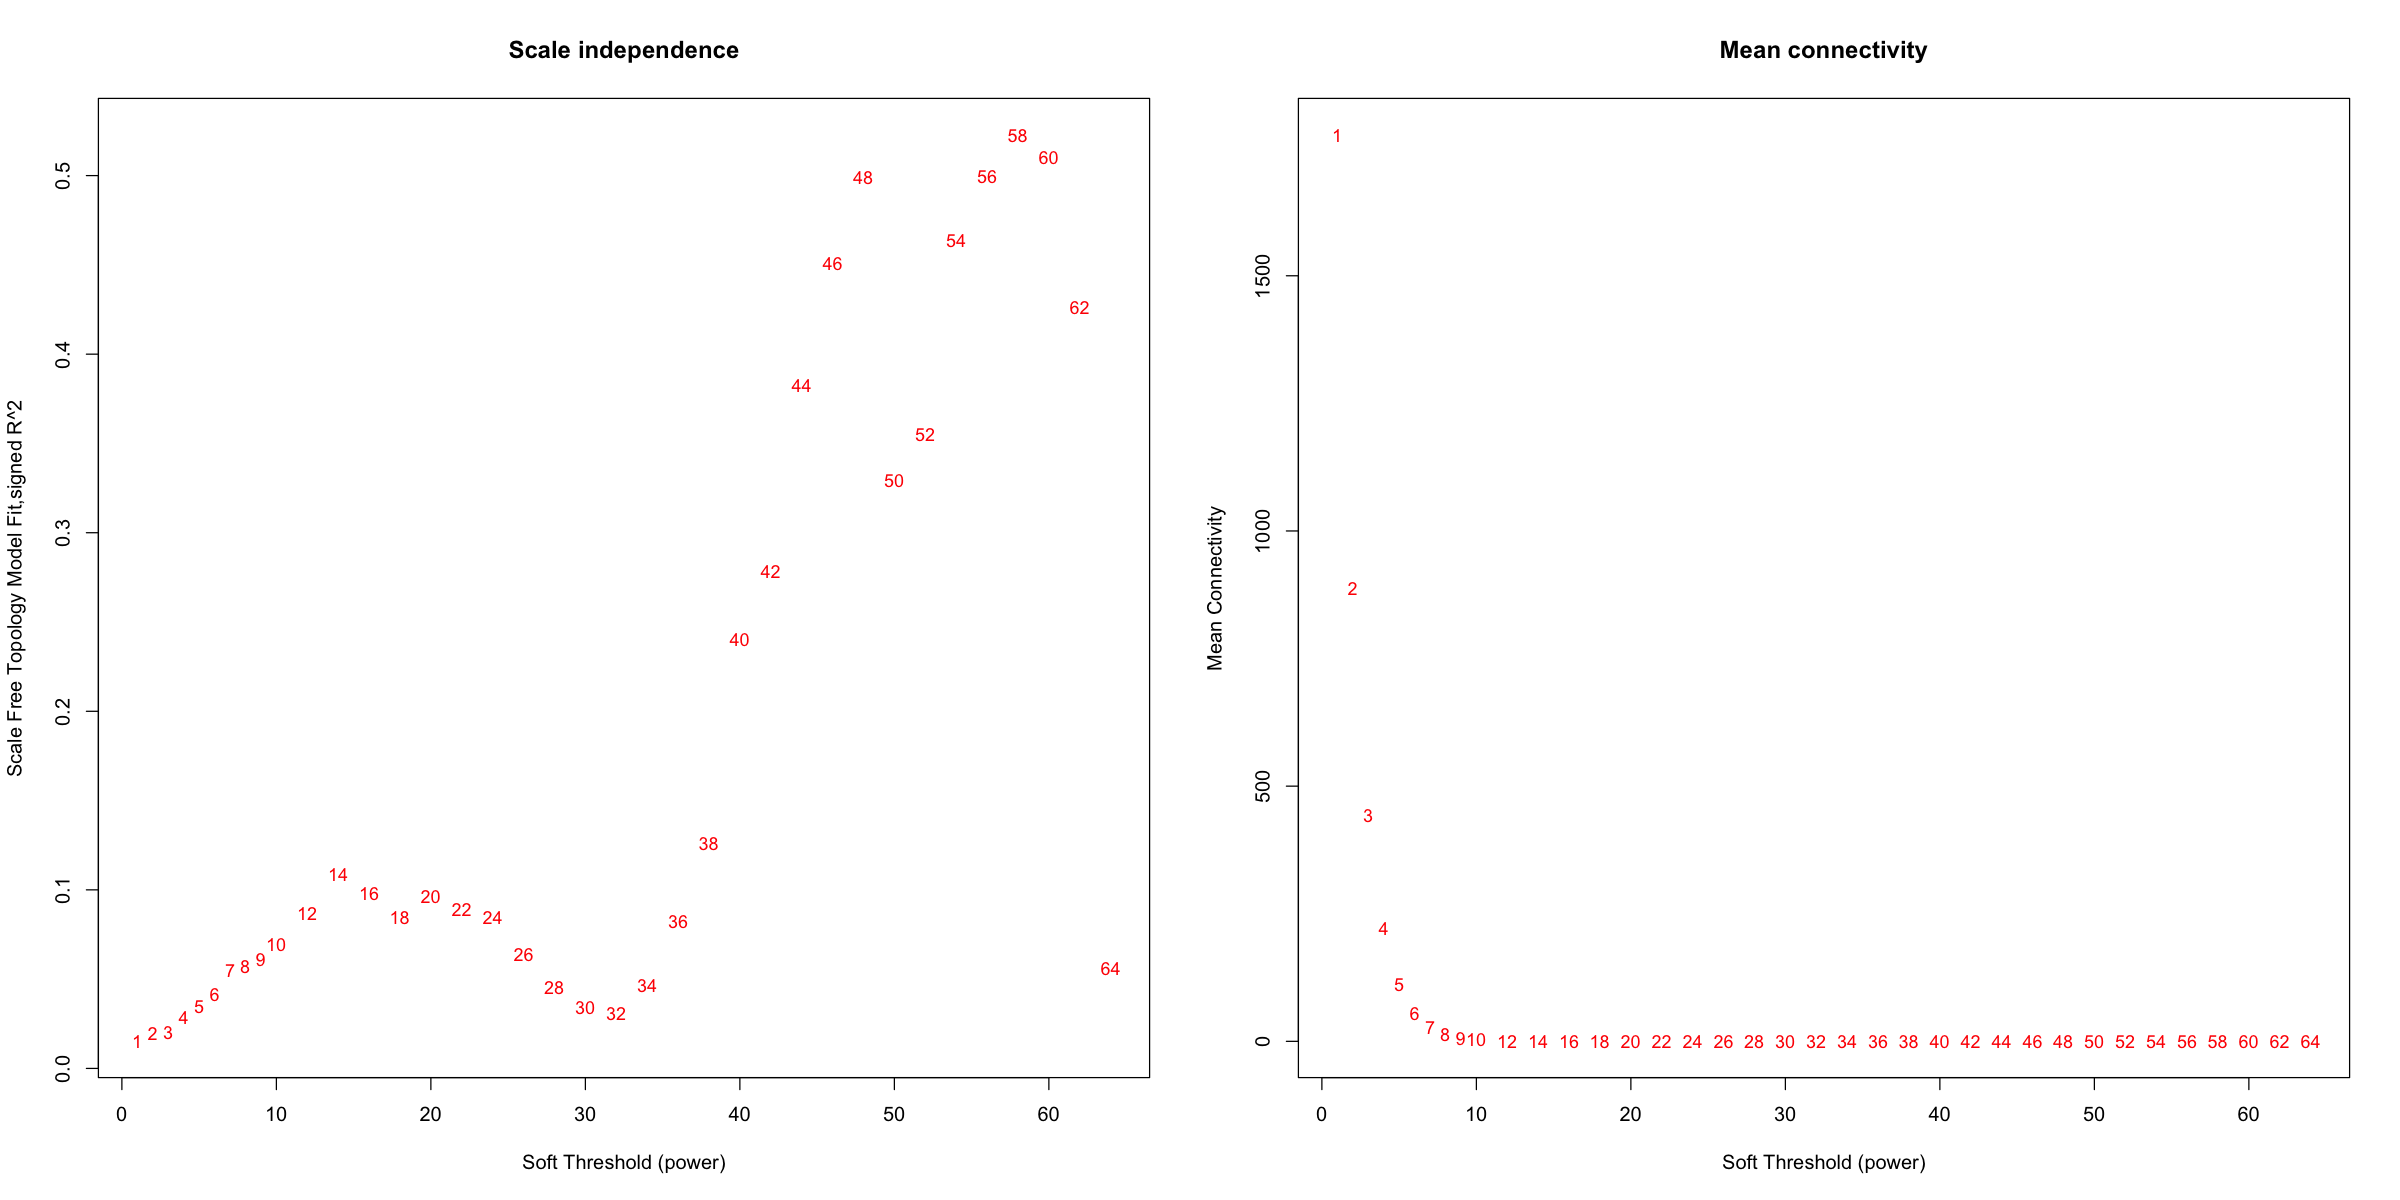

In [21]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,2))
cex1 = 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
#pdf("./Plots/ColALL_TALL_softPowerTesting.pdf", width = 7, height = 7)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],labels=powers,cex=cex1,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
#dev.off()

The plot on the left above shows the lack of the sum-normalized sparCC data to reach a correlation of 0.8, and according to the Scale Free Criterion, this indicates a lack of approximate scale free topology. The plot on the right shows that when the soft power threshold is adjusted to maximize the Scale Free Topology Fit, the mean connectivity plummets to 0. 

Below, I include the hierarchical plot of distances of the dissimilarities of the Topological Overlap Measure. As one would expect, it's a mess.

In [ ]:
#adjacency
softPower <- 58
sparcc_coral_data_adjacency <- adjacency.fromSimilarity(similarity = sparcc_coral_data, power = softPower)

#calculates topological overlap
sparcc_coral_data_TOM <- TOMsimilarity(sparcc_coral_data_adjacency)
sparcc_coral_data_dissTOM = 1-sparcc_coral_data_TOM
sparcc_coral_data_Tree = hclust(as.dist(sparcc_coral_data_dissTOM), method = "average")
plot(sparcc_coral_data_Tree, xlab="", sub="", main = "Metabolite clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)
minModuleSize = 30
dynamicMods = cutreeDynamic(dendro = sparcc_coral_data_Tree, distM = sparcc_coral_data_dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize)
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

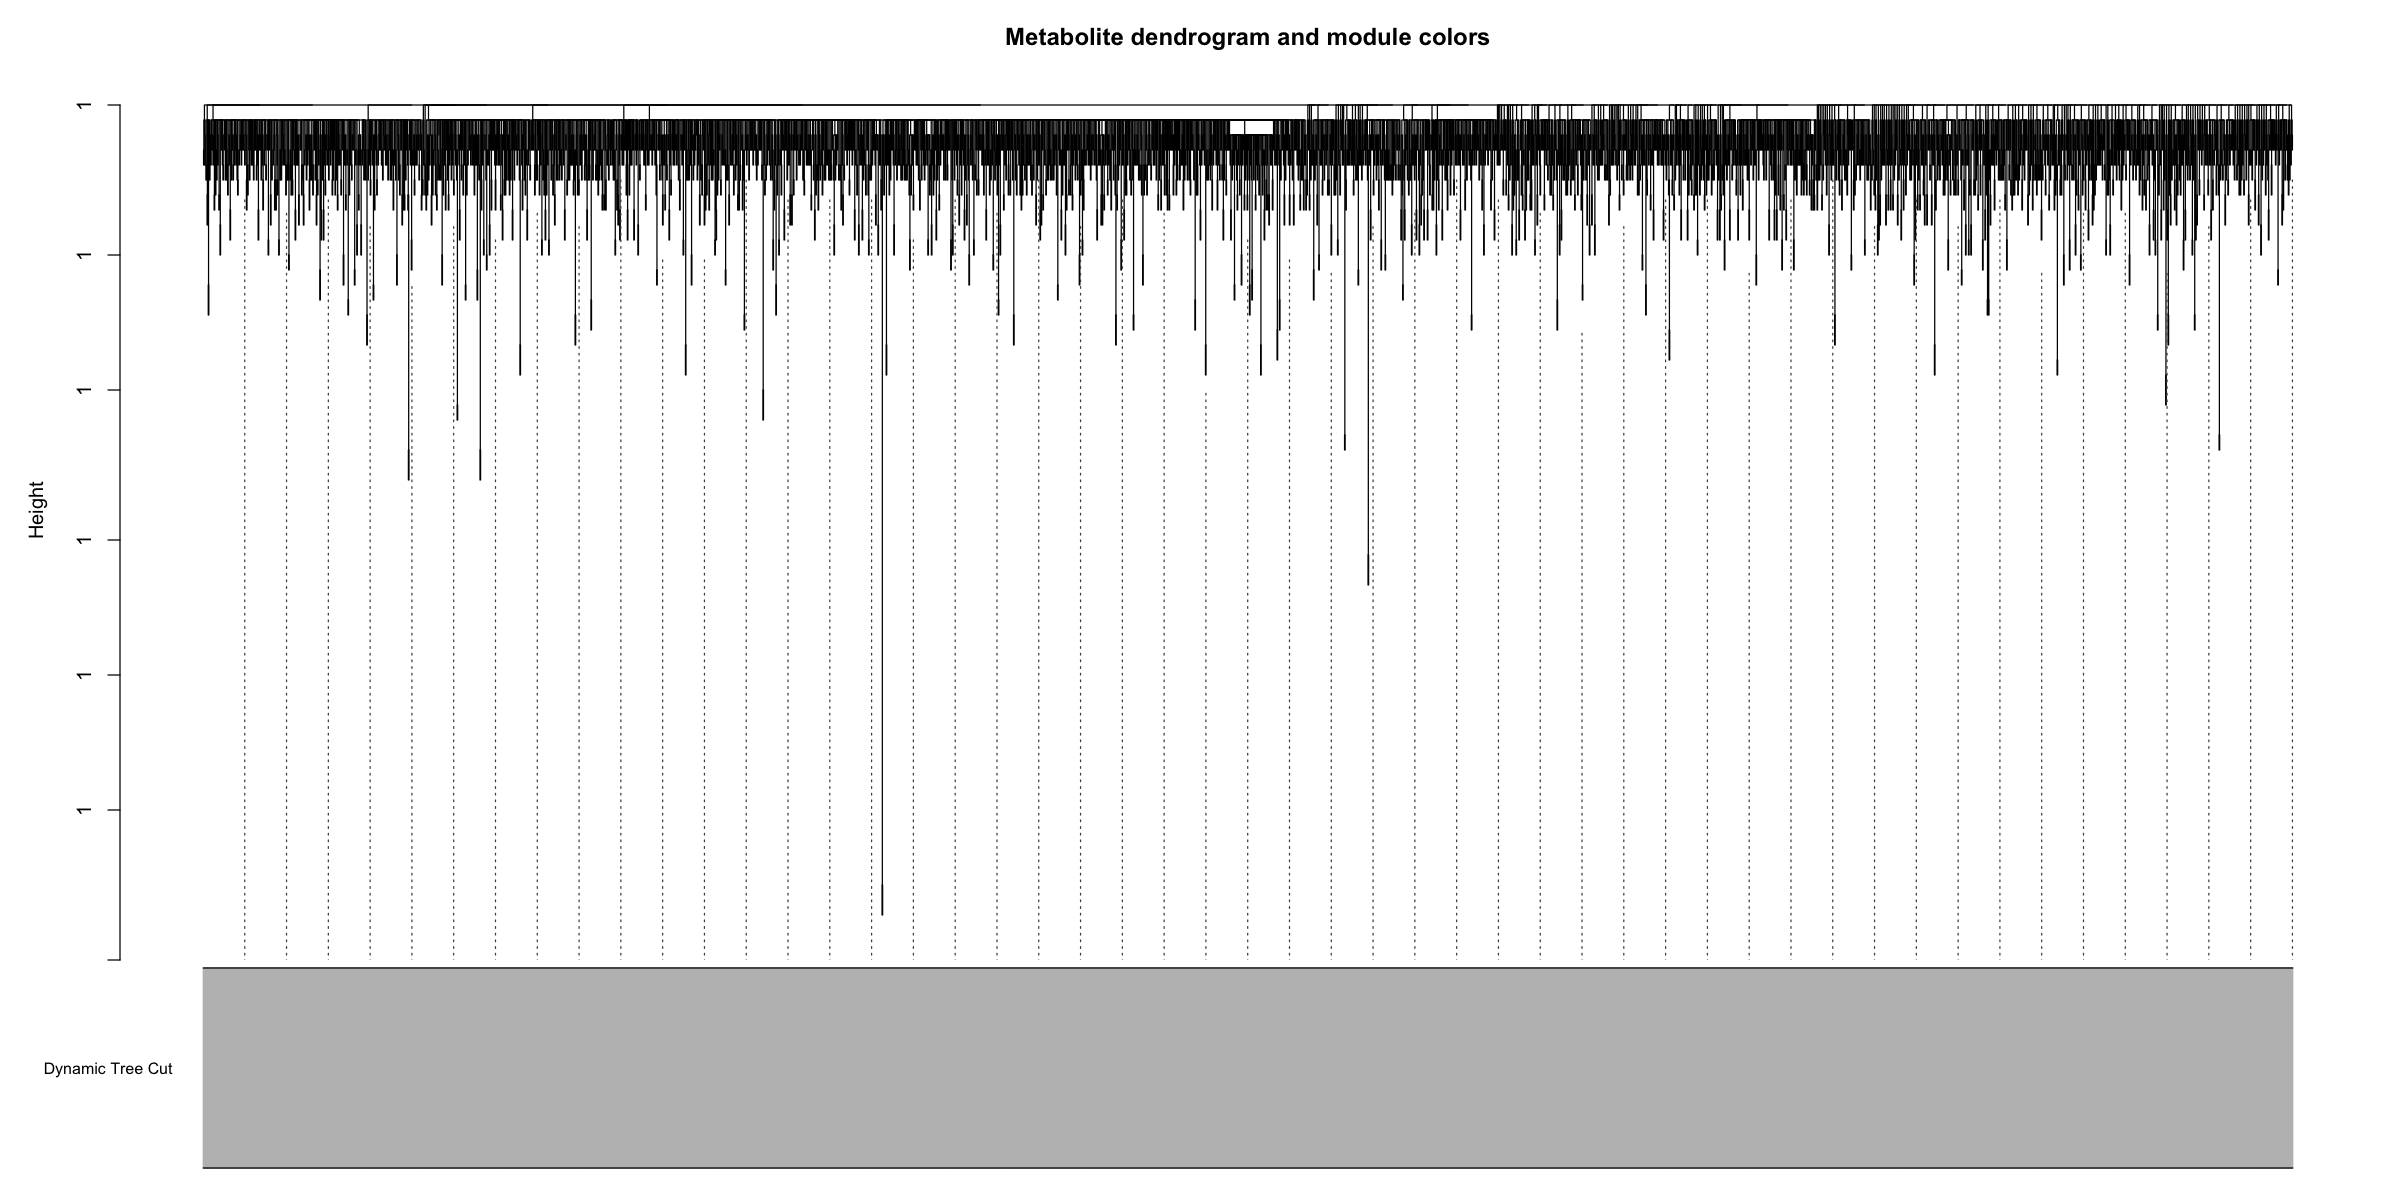

In [23]:
plotDendroAndColors(sparcc_coral_data_Tree, dynamicColors, 
                    "Dynamic Tree Cut", dendroLabels = FALSE, 
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05,
                    main = "Metabolite dendrogram and module colors")

The grey column indicates the lack of any discernible cluster in the hierarchy.

### Non-sum-Normalized SparCC Network Construction

It seems like the sum-normalized data does not lend itself toward a Scale Free Topology with the coral data; so, instead, we can try with the sparCC similarity values calculated from non-sum-normalized data. 

In [25]:
load("data/sparcc_coral_data_master_huayingfang.RData")

sparcc_coral_data <-
  sparcc_coral_data_all %>% 
  as.data.frame() %>%
  .[,3561:7120] %>%
  as.matrix() %>%
  apply(., 2, function(x) round(x, 5)) %>%
  #for a "signed" similarity
  apply(., 2, function(x) (x + 1)/2)
        
#only will be using one of the df's from the several loaded
rm(sparcc_coral_data_all, 
   sparcc_coral_data_Col2_T2, 
   sparcc_coral_data_Col2_T1, 
   sparcc_coral_data_Col3_T2, 
   sparcc_coral_data_Col3_T1)

Below, I have generated the same plots as I did above to determine whether the non-sum-normalized sparCC calues lend themselves to Scale Free Topology.

In [ ]:
powers <- c(1:10, seq(12,20,by=2))
sft <- pickSoftThreshold.fromSimilarity(similarity = sparcc_coral_data, powerVector = powers, verbose = 2,moreNetworkConcepts=TRUE)
sizeGrWindow(9, 5)
par(mfrow = c(1,2))
cex1 = 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
#pdf("./Plots/ColALL_TALL_notransform_softPowerTesting.pdf", width = 7, height = 7)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],labels=powers,cex=cex1,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
#dev.off()

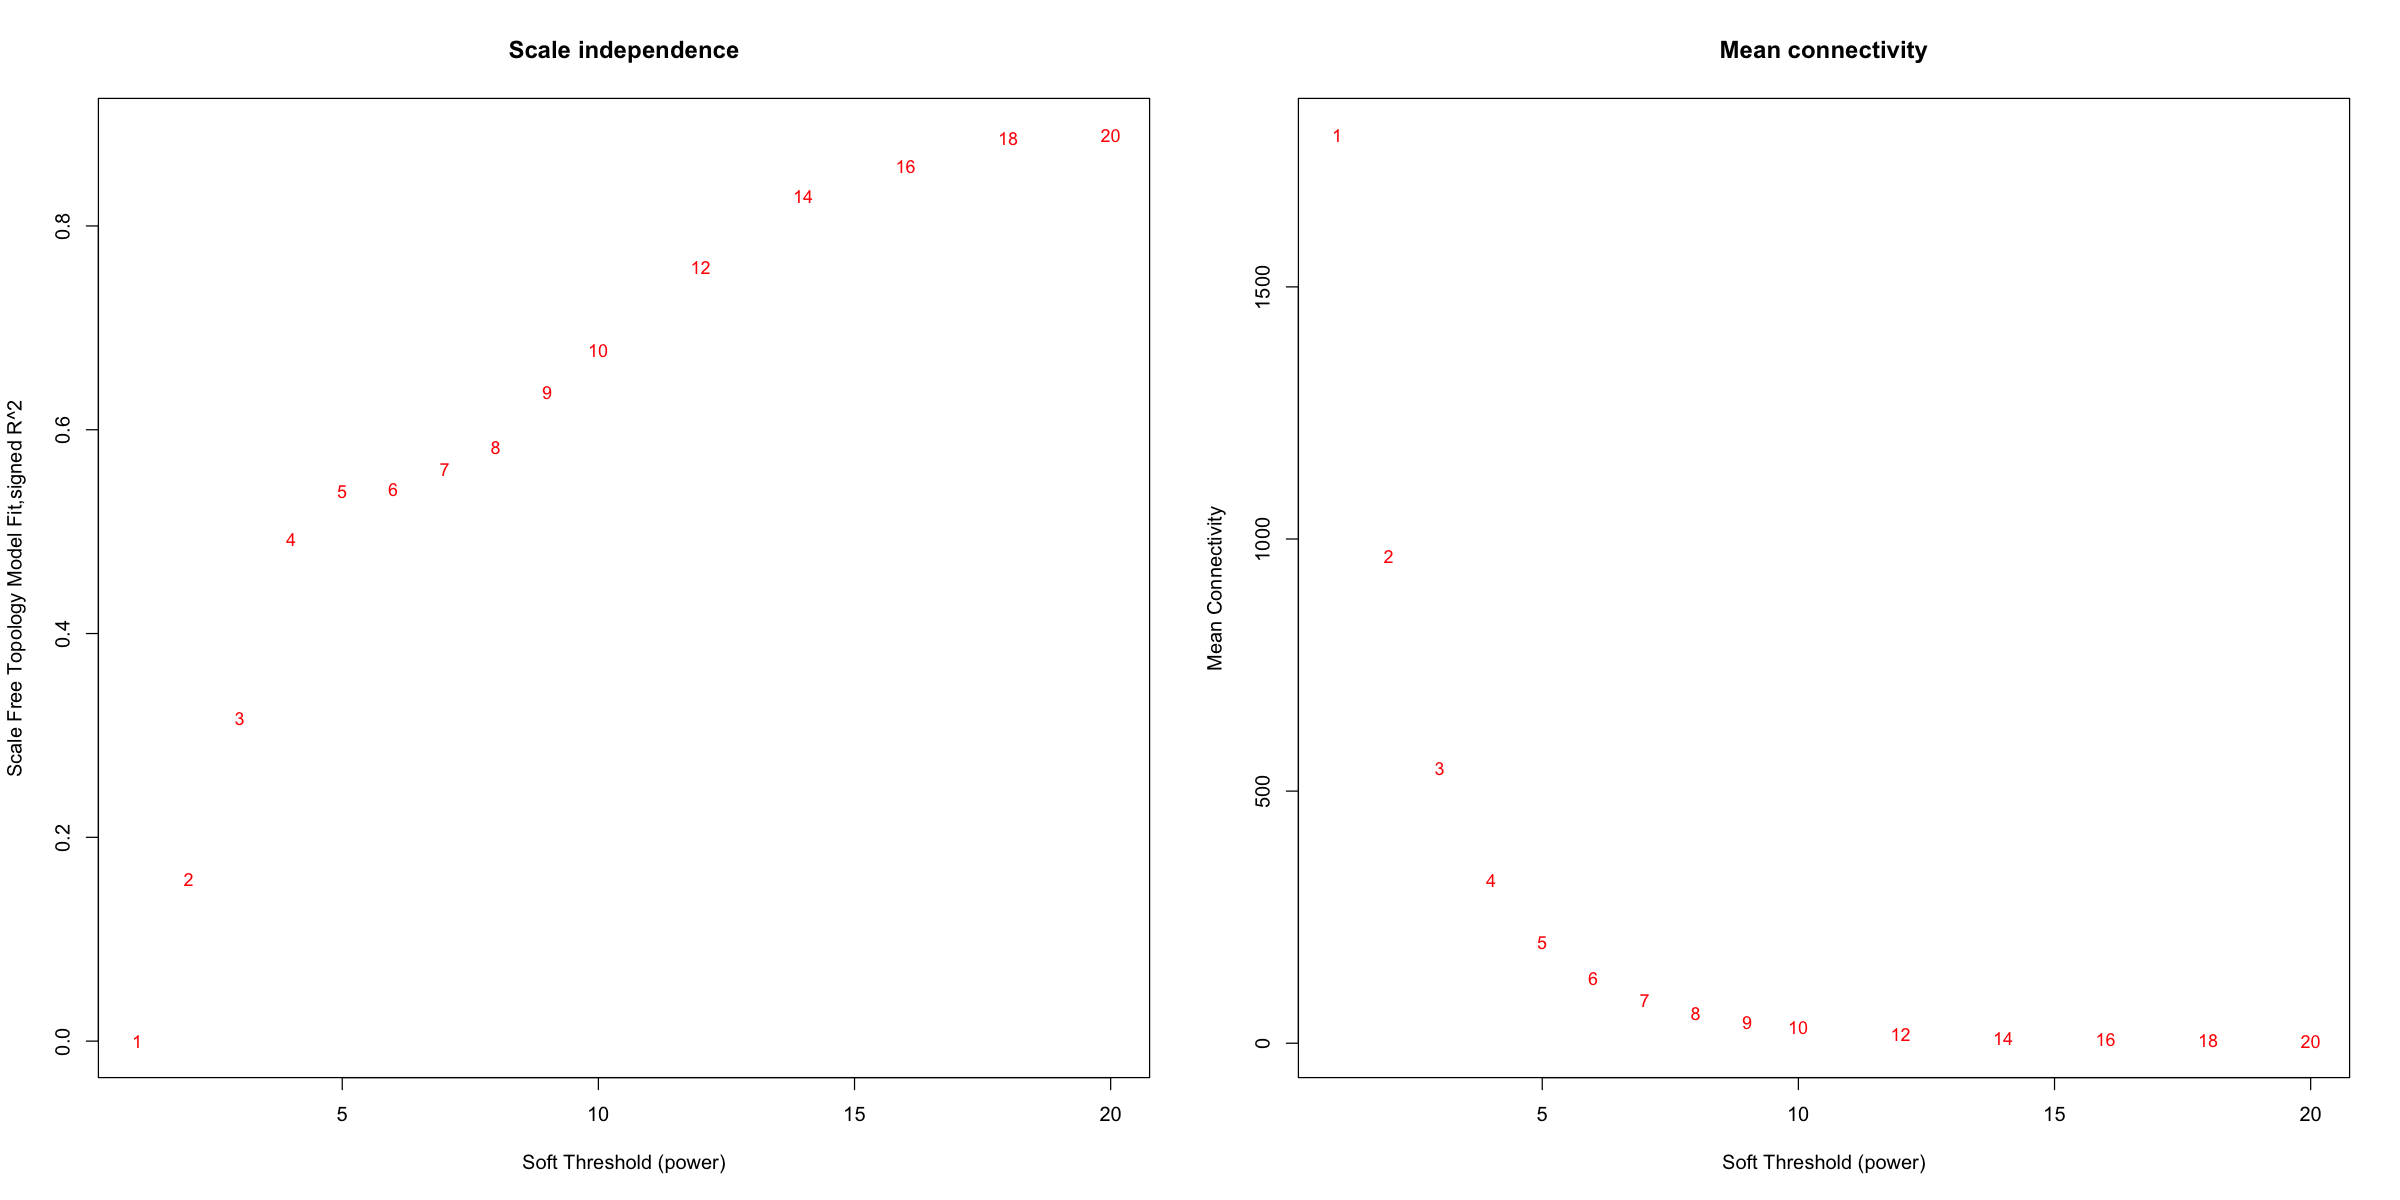

In [27]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,2))
cex1 = 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
#pdf("./Plots/ColALL_TALL_softPowerTesting.pdf", width = 7, height = 7)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],labels=powers,cex=cex1,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
#dev.off()

On the plot on the left, we can see the Scale Free Criterion is met with multiple correlations above the 0.8 threshold. The "plateau" begins around a soft threshold of 18, and so I use that value as my soft threshold when creating the adjacency matrix. The plot on the right shows the mean connectivity at a soft threshold of 18 is reduced to nearly 0, which means the soft threshold has reduced a majority of the metabolites to 0.

After calculating the adjacency table (i.e. the network) with a soft threshold of 18, we have to calculate the TOM; then, the dissimilarity for the purposes of clustering.

In [ ]:
#calculates the adjacency of the variables wrt each other; adjacency = network
softPower <- 18
sparcc_coral_data_adjacency <- adjacency.fromSimilarity(similarity = sparcc_coral_data, power = softPower)

#calculates topological overlap
sparcc_coral_data_TOM <- TOMsimilarity(sparcc_coral_data_adjacency)
sparcc_coral_data_dissTOM = 1-sparcc_coral_data_TOM
sparcc_coral_data_Tree = hclust(as.dist(sparcc_coral_data_dissTOM), method = "average")
#plots tree of TOM
plot(sparcc_coral_data_Tree, 
     xlab="", 
     sub="", 
     main = "Metabolite clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)

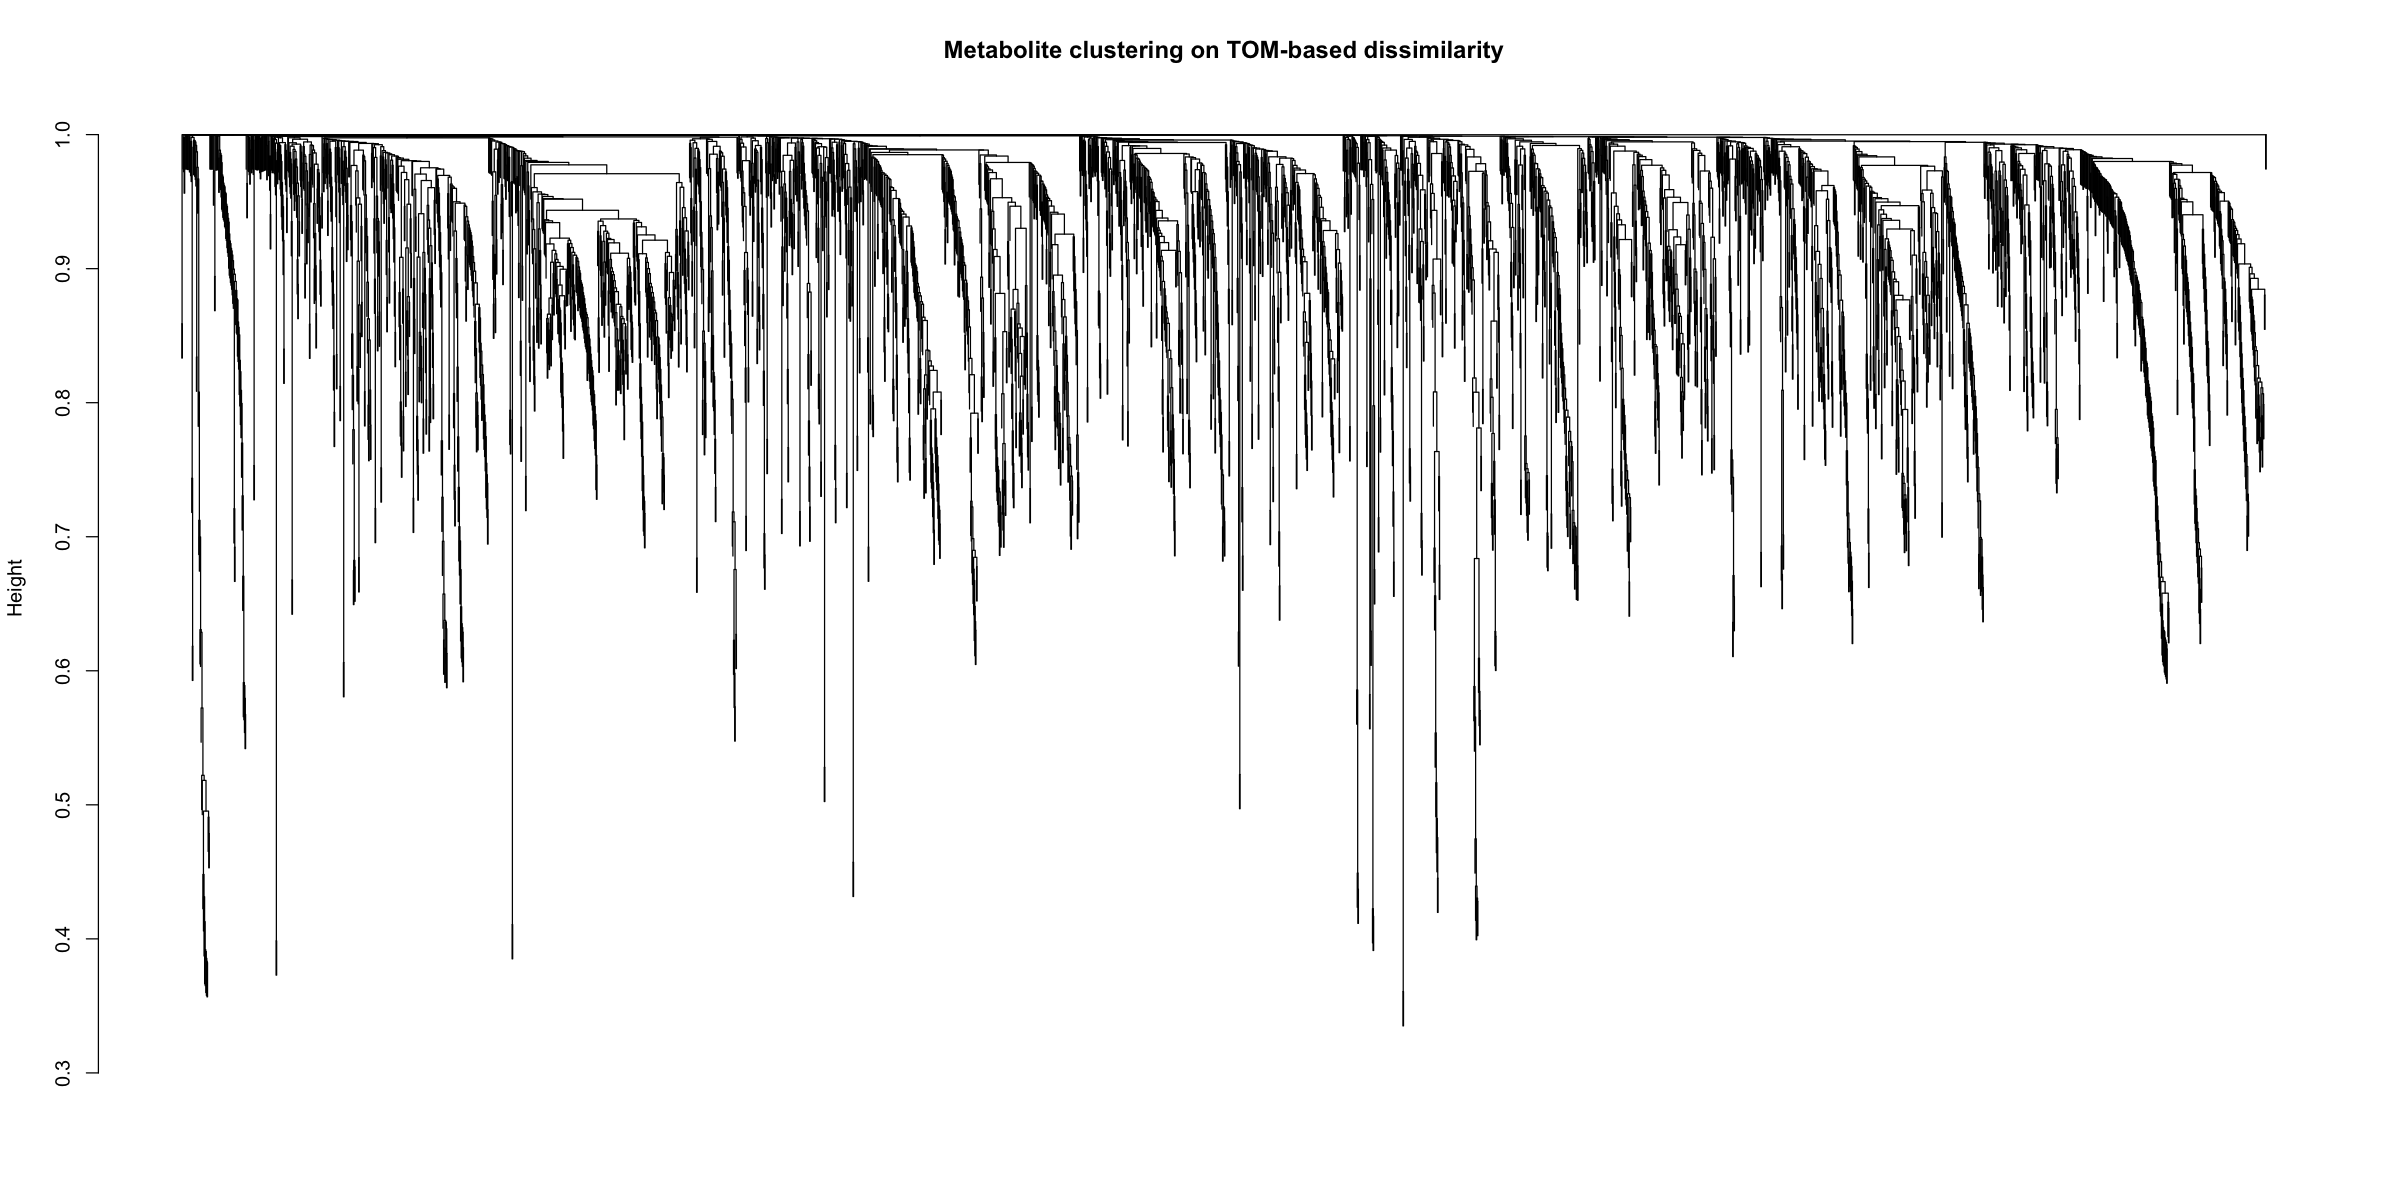

In [29]:
#plots tree of TOM
plot(sparcc_coral_data_Tree, 
     xlab="", 
     sub="", 
     main = "Metabolite clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)

So, we now have a visual representation of our network. The next step is to cluster the tree into modules:

In [ ]:
minModuleSize = 30
dynamicMods = cutreeDynamic(dendro = sparcc_coral_data_Tree, distM = sparcc_coral_data_dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize)
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

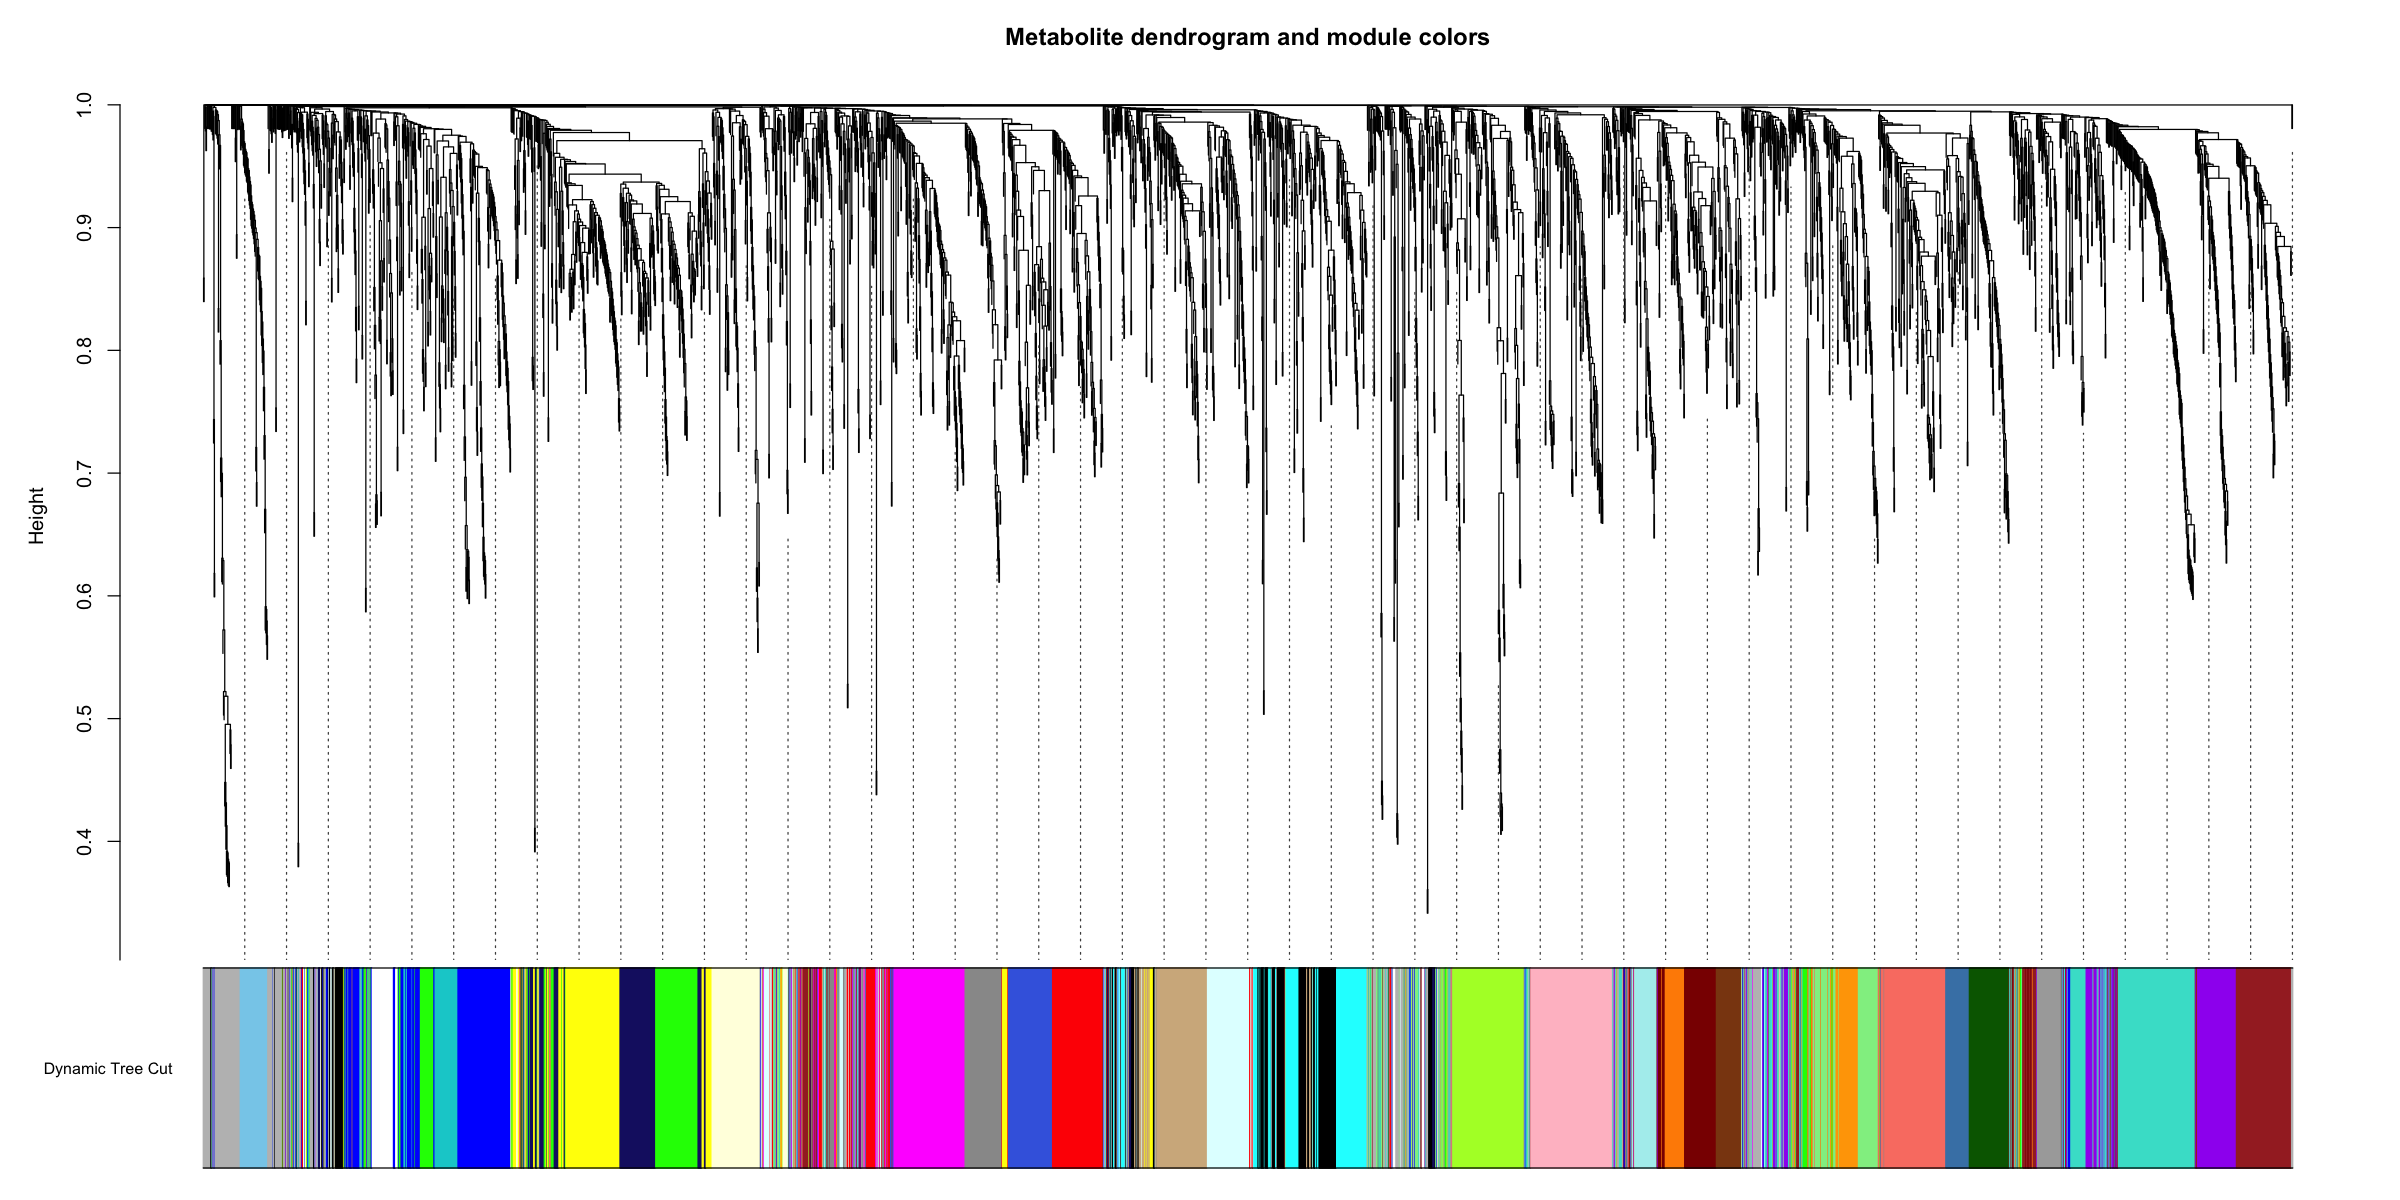

In [31]:
plotDendroAndColors(sparcc_coral_data_Tree, dynamicColors, 
                    "Dynamic Tree Cut", dendroLabels = FALSE, 
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05,
                    main = "Metabolite dendrogram and module colors")

After clustering the tree, we are returned the modules with associated colors. Considering some of these modules are relatively small and close together, we may anticipate some may be merged together after our next step, which is to create a hierarchical tree of the correlations of the first principal components of each of the modules with respect to each other.

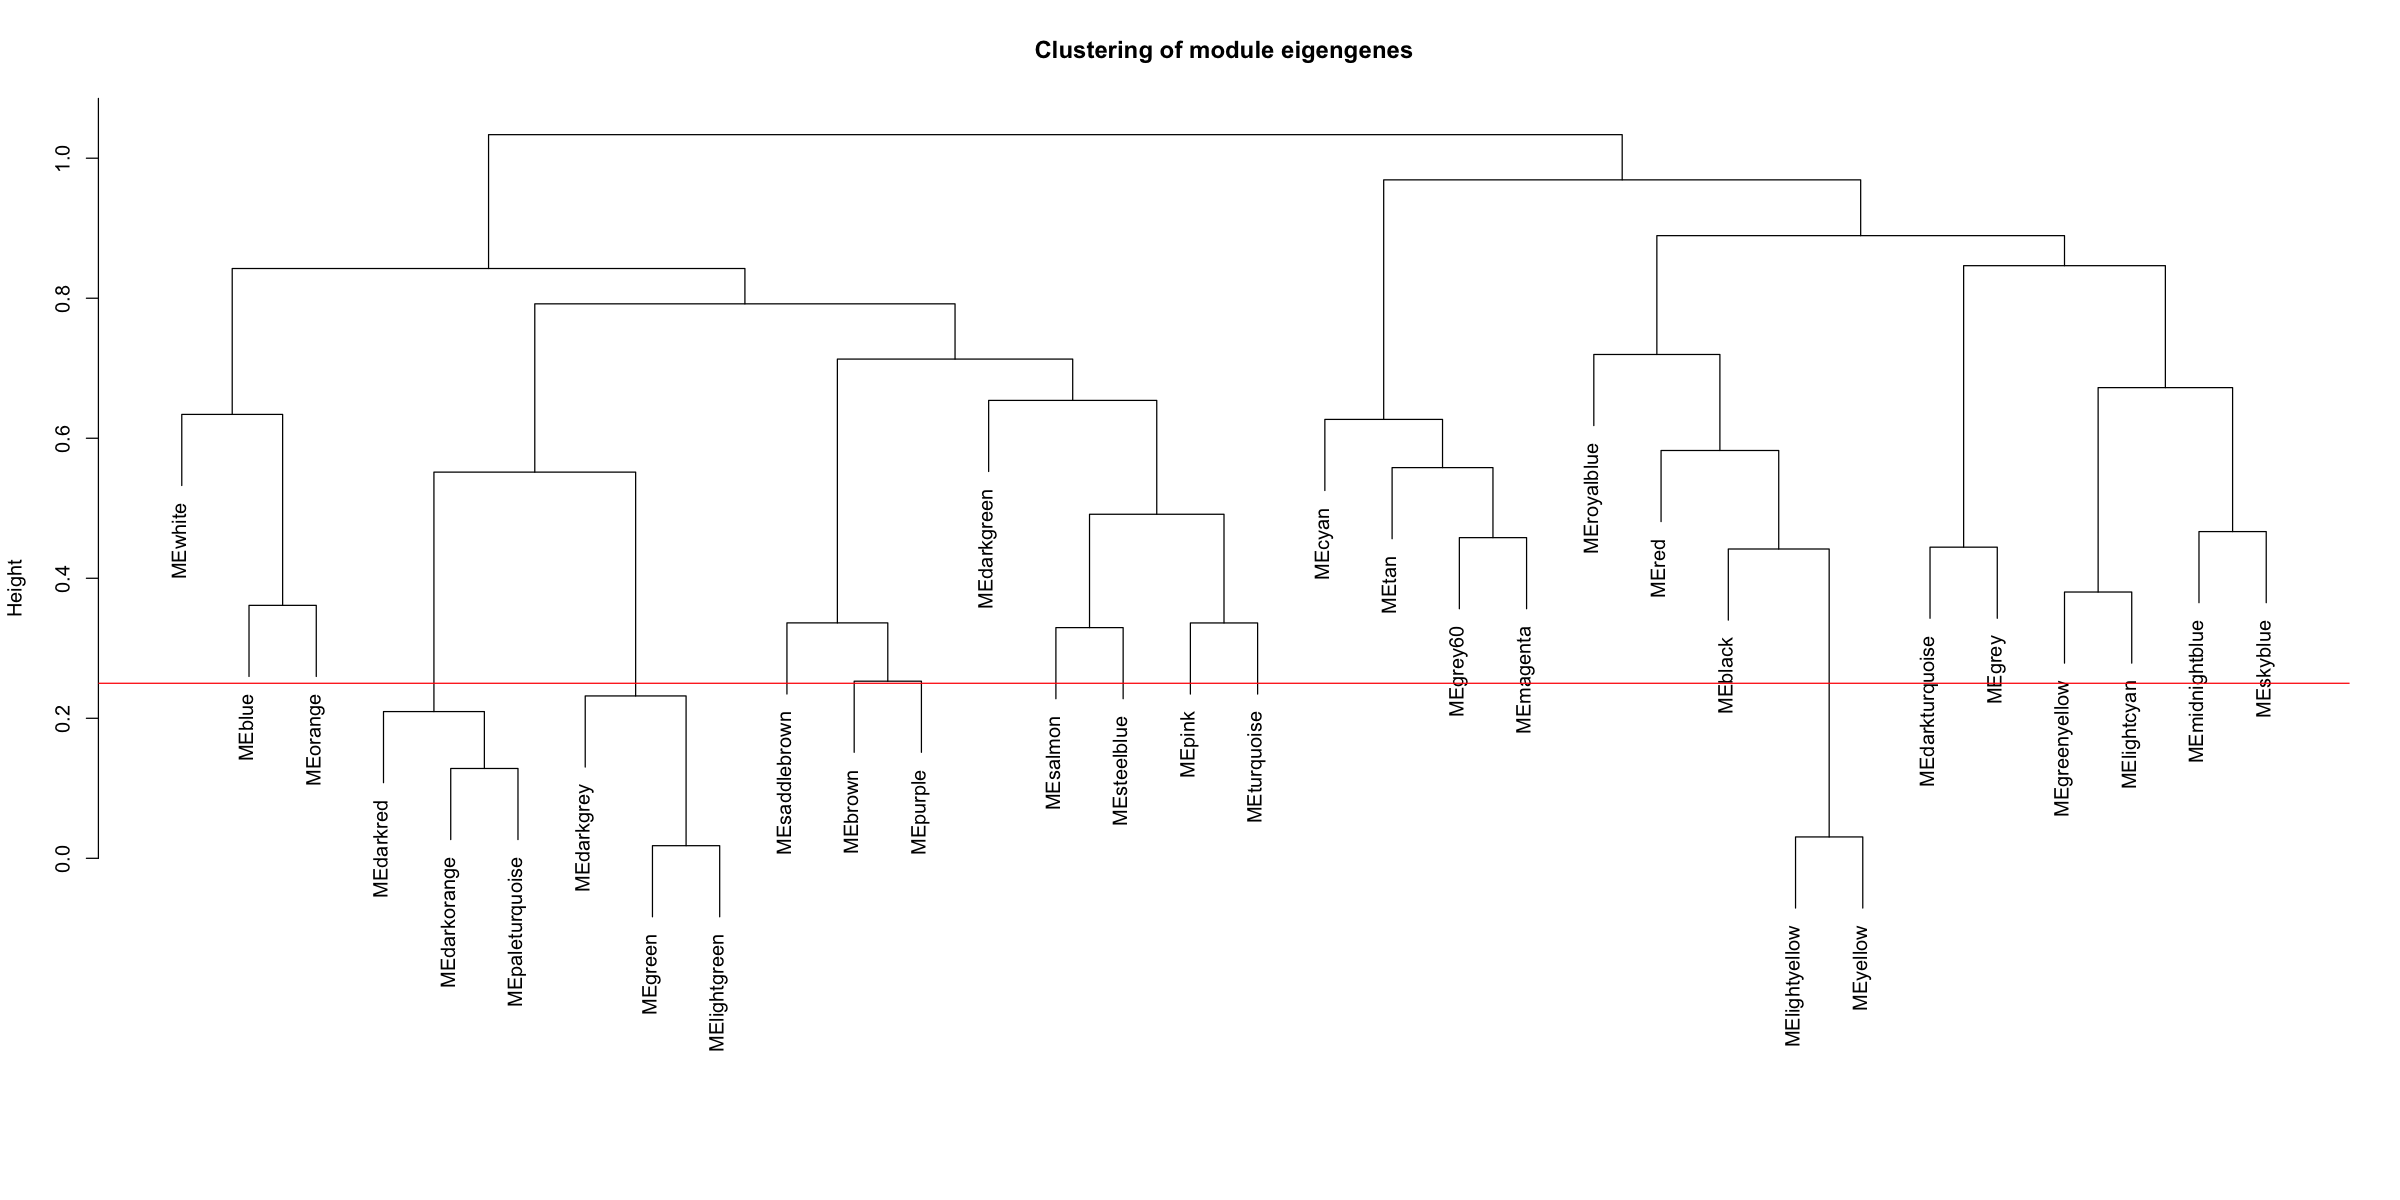

In [32]:
MEList = moduleEigengenes(coral_data[,16:ncol(coral_data)], colors = dynamicColors, scale = F)
MEs = MEList$eigengenes
MEDiss = 1-cor(MEs);
METree = hclust(as.dist(MEDiss), method = "average");

plot(METree, main = "Clustering of module eigengenes",xlab = "", sub = "")
MEDissThres = 0.25
# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")

As can be seen with the red cutoff line, many of the modules are going to be combined together, reducing the total number of modules which will have to be correlated with the traits of interest.

In [ ]:
# Call an automatic merging function
merge = mergeCloseModules(coral_data[,16:ncol(coral_data)] , 
                          dynamicColors, 
                          MEs = MEs, 
                          cutHeight = MEDissThres, 
                          verbose = 3)
# The merged module colors
mergedColors = merge$colors
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs

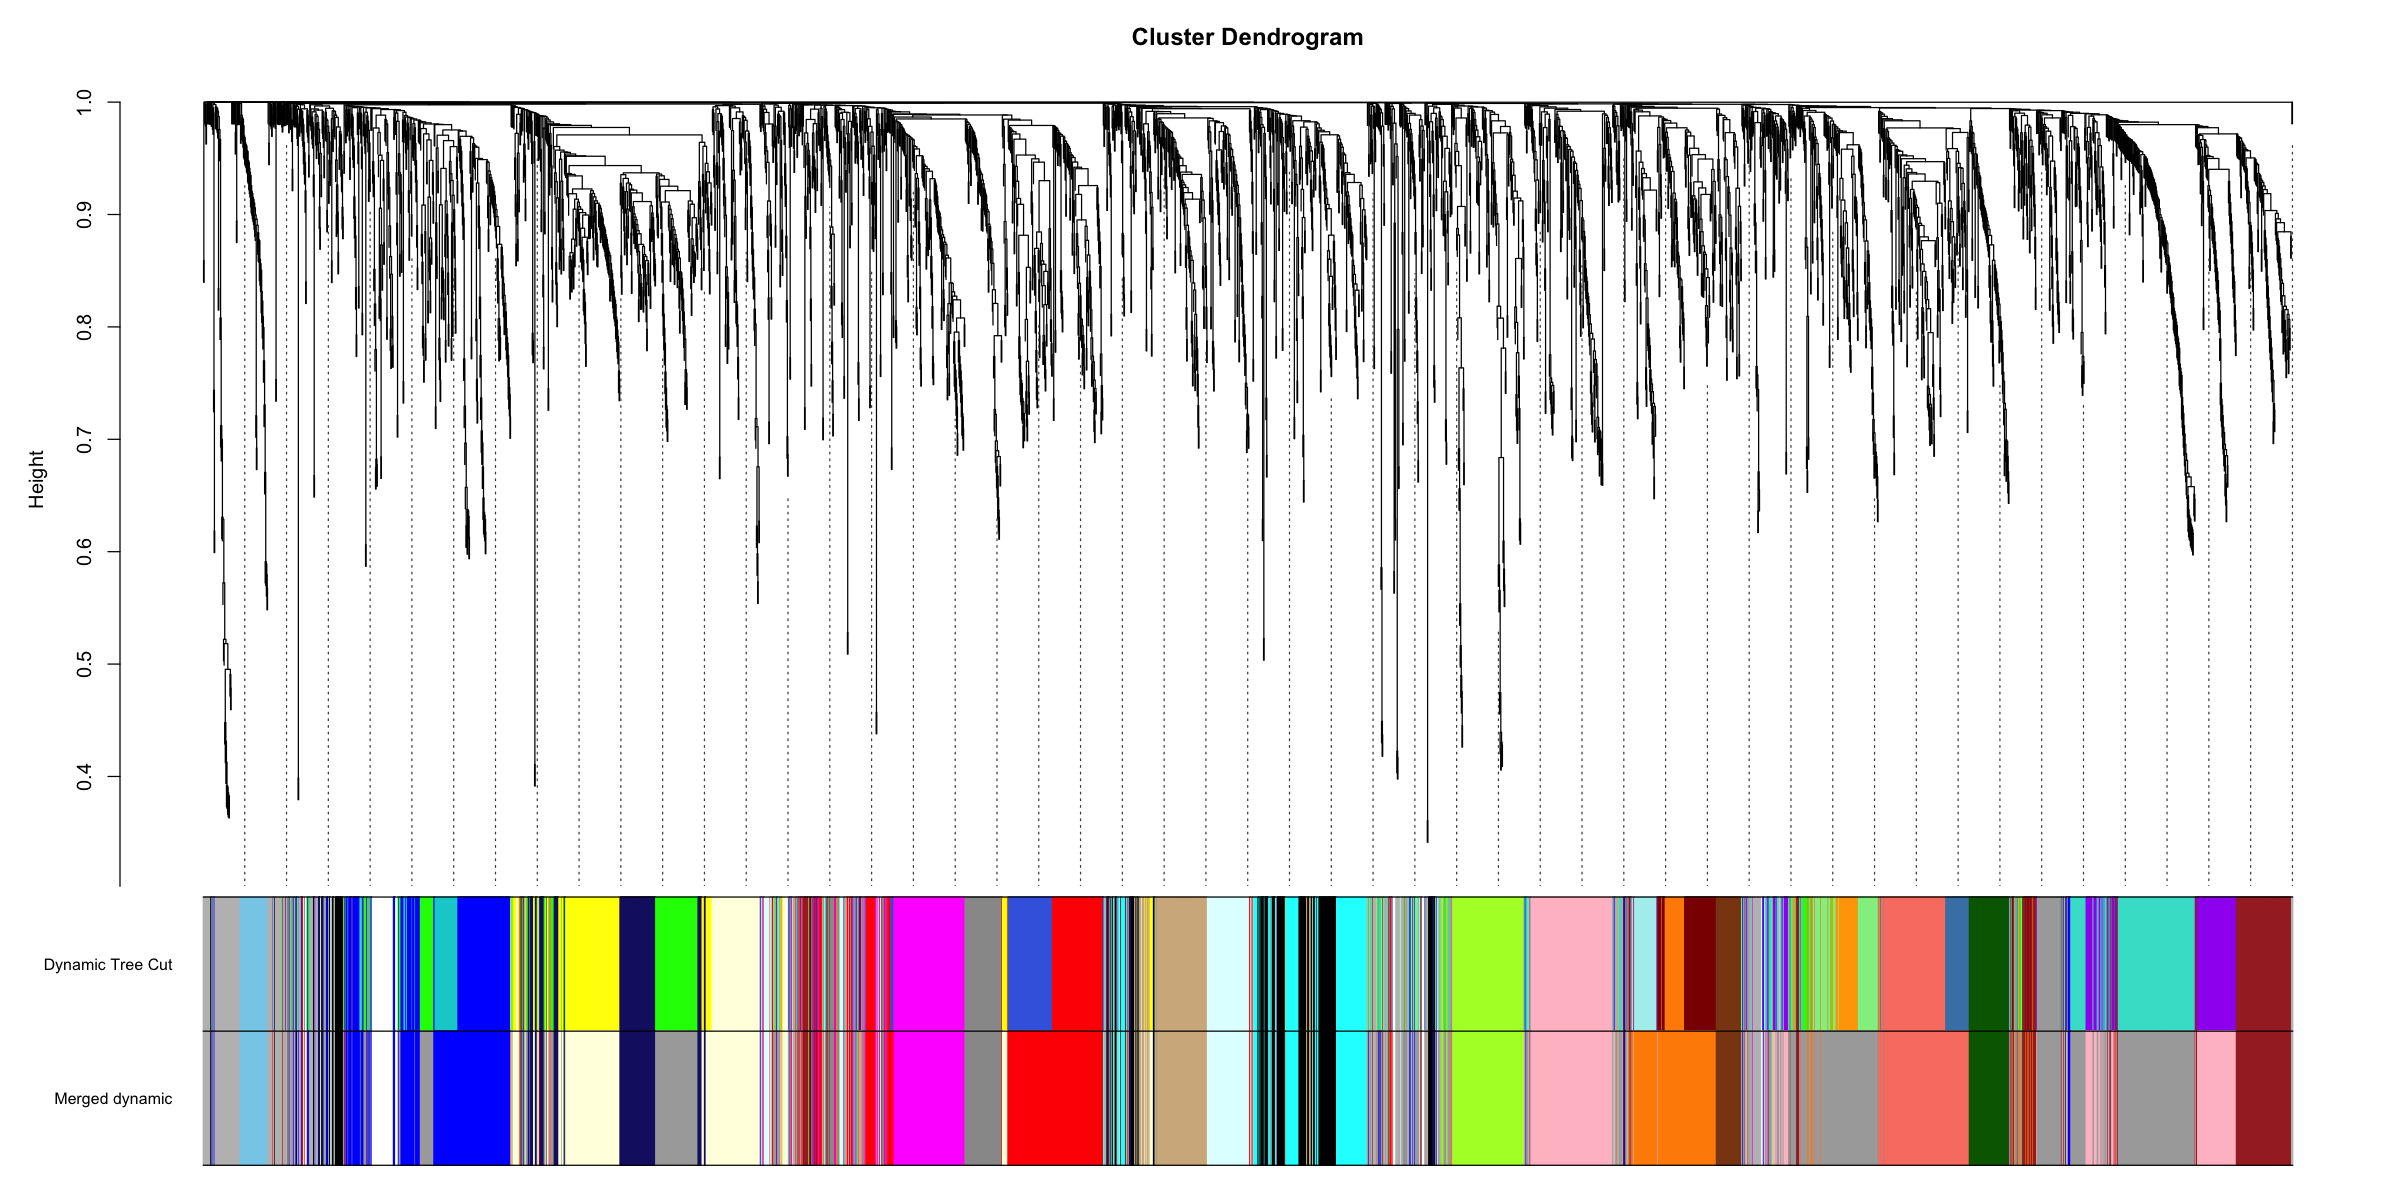

In [34]:
plotDendroAndColors(sparcc_coral_data_Tree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05)

We can now relate the modules we see here with the coral attributes / phenotypes via a heatmap by correlating the first principal components of each module with the coral attributes. 

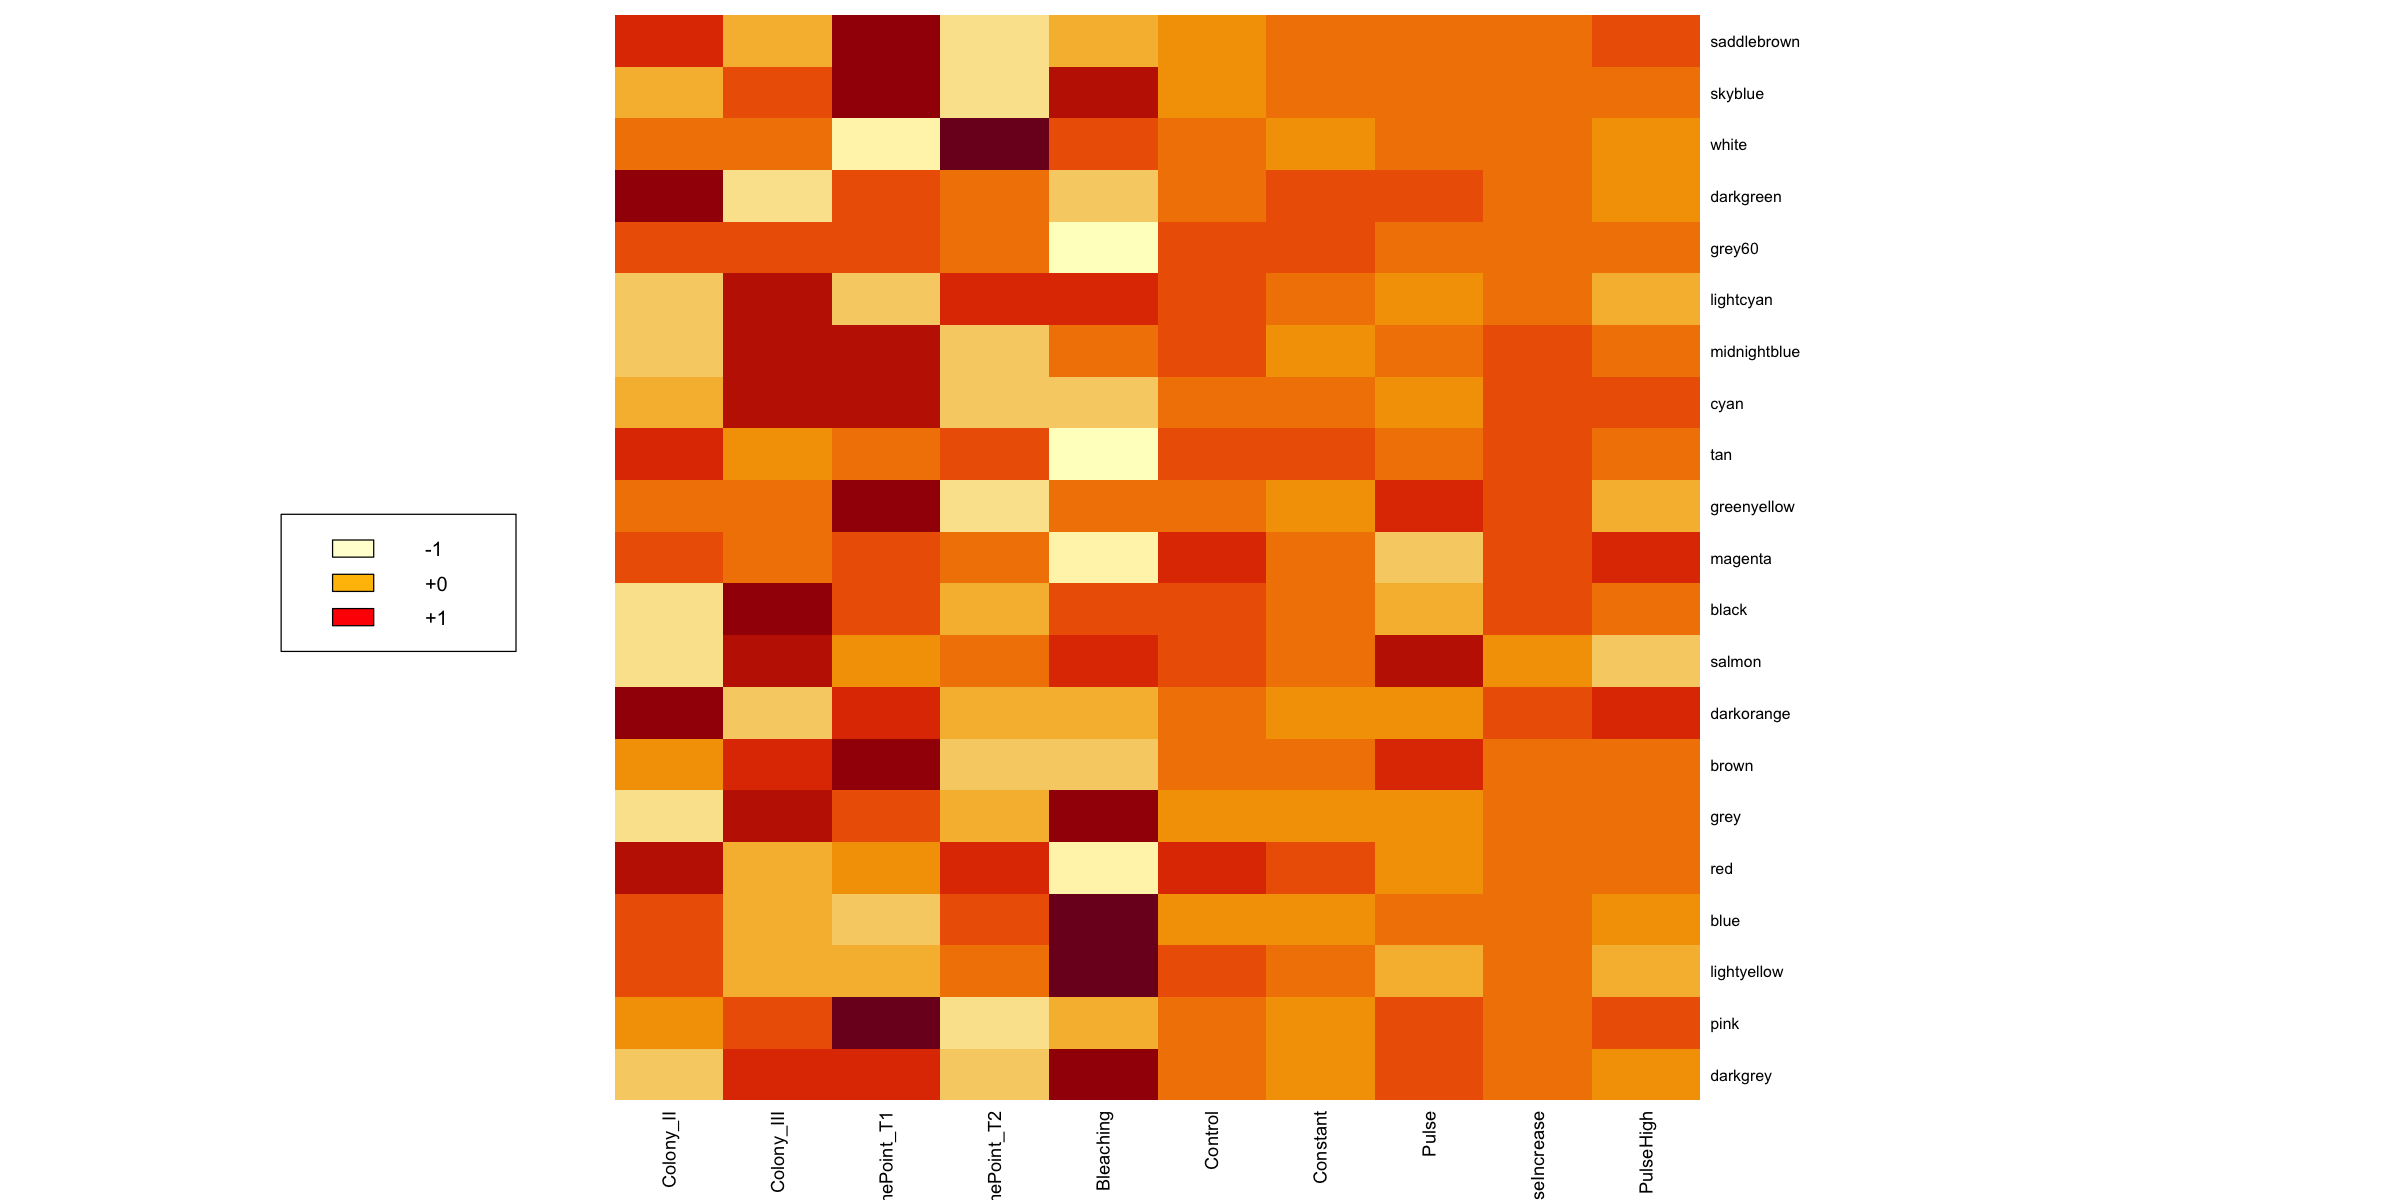

In [40]:
#get hub metabolites
moduleColors = mergedColors

moduleColors_andCount <-
  table(moduleColors) %>% 
  as.data.frame() %>% 
  arrange(desc(Freq))

# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;

sparcc_coral_data_traits <-
  coral_data %>%
  select(Colony, Temperature.treatment, BleachingHistoryPhenotype, TimePoint) %>%
  mutate(Colony_II = ifelse(str_length(as.character(Colony)) == 2, 1, 0),
         Colony_III = ifelse(str_length(as.character(Colony)) == 3, 1, 0),
         Control = ifelse(Temperature.treatment == "Control", 1, 0),
         Constant = ifelse(Temperature.treatment == "Constant", 1, 0),
         Pulse= ifelse(Temperature.treatment == "Pulse", 1, 0),
         PulseIncrease = ifelse(Temperature.treatment == "Pulse Increase", 1, 0),
         PulseHigh = ifelse(Temperature.treatment == "Pulse High", 1, 0),
         Bleaching = ifelse(BleachingHistoryPhenotype == "Bleached", 1, 0),
         TimePoint_T1 = ifelse(TimePoint == "T1", 1, 0),
         TimePoint_T2 = ifelse(TimePoint == "T2", 1, 0)) %>%
  select(Colony_II, Colony_III, 
         TimePoint_T1, TimePoint_T2, 
         Bleaching, 
         Control, Constant, Pulse, PulseIncrease, PulseHigh)

moduleTraitCor <- 
  cor(MEs, sparcc_coral_data_traits, use= "p") %>%
  as.data.frame() %>%
  rownames_to_column(var = "modules") %>%
  mutate(modules = str_remove(modules, "ME")) %>%
  left_join(., moduleColors_andCount, by = c("modules"="moduleColors")) %>%
  arrange(desc(Freq)) %>%
  column_to_rownames(var = "modules") %>%
  select(-Freq) %>%
  as.matrix()

#heatmap
heatmap(moduleTraitCor, Colv = NA, Rowv = NA, cexCol = 1.1)
legend(x="left", legend=c("-1", "+0", "+1"), fill=heat.colors(12)[c(12,7,1)])

The coral attribute with the greatest range of correlation with the modules is the Bleaching History phenotype, which has strong correlations with some of the largest modules (darkgrey, lightyellow, blue, and grey). The dark grey and grey modules also have a relatively strong correlation with Colony_III, while the lightyellow and blue are relativey strong with Colony_II.

To better understand what metabolites are grouping clustered together in the modules, which are strongly correlated with the Bleaching History Phenotype, I extracted the metabolites from those attributes, which have compound identifiers:

In [53]:
metaboliteModuleExtract <- function(module){
    
    colnames(coral_data[,16:ncol(coral_data)])[moduleColors == module] %>%
    str_split(pattern = "_(?!.*_)") %>%
    do.call(rbind, .) %>%
    as.data.frame() %>%
    select(V2) %>%
    filter(V2 != "N.A") %>%
    mutate(`Named Metabolites` = str_remove(V2, pattern = "Spectral.Match.to.")) %>%
    select(`Named Metabolites`)
    
}

metaboliteModuleExtract(module = "darkgrey") %>%
  rename("darkgrey"="Named Metabolites") %>%
  kbl(format = "html") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()
metaboliteModuleExtract(module = "lightyellow") %>%
  rename("lightyellow"="Named Metabolites") %>%
  kbl(format = "html") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()
metaboliteModuleExtract(module = "blue") %>%
  rename("blue"="Named Metabolites") %>%
  kbl(format = "html") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()
metaboliteModuleExtract(module = "grey") %>%
  rename("grey"="Named Metabolites") %>%
  kbl(format = "html") %>%
  kable_classic(full_width = F, html_font = "Cambria", font_size = 20) %>%
  as.character() %>%
  display_html()

darkgrey 
 
 
 
 
 MoNA.692793.1.Butanamine..N.N.dibutyl. 
 
 
 PALMITOYLCARNITINE 
 
 
 Lyso.PAF.C.18.from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 15.S..15.Methylprostaglandin.E1.from.NIST14 
 
 
 Pinolenic.acid.from.NIST14 
 
 
 LAUROYLCARNITINE 
 
 
 terpestacin 
 
 
 Pinolenic.acid.from.NIST14 
 
 
 1.Linoleoylglycerol.from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14

lightyellow 
 
 
 
 
 Lyso.PC.16.0..from.NIST14 
 
 
 1.Stearoyl.2.hydroxy.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 1.Stearoyl.2.hydroxy.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 Lyso.PC.16.0..from.NIST14 
 
 
 9.12.15.Octadecatrienoic.acid..3..hexopyranosyloxy..2.hydroxypropyl.ester...9Z.12Z.15Z.. 
 
 
 9.12.15.Octadecatrienoic.acid..3..hexopyranosyloxy..2.hydroxypropyl.ester...9Z.12Z.15Z.. 
 
 
 PAF.C.16.from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 1..9Z.Octadecenoyl..sn.glycero.3.phosphocholine.from.NIST14 
 
 
 1.Stearoyl.2.hydroxy.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 1.Arachidoyl.2.hydroxy.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 Pinolenic.acid.from.NIST14 
 
 
 1.Hexadecanoyl.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 12.13..Epoxy.9Z.octadecenoic.acid.from.NIST14 
 
 
 1.Octadecanoyl.2..5Z.8Z.11Z.14Z.eicosatetraenoyl..sn.glycero.3.phosphocholine.from.NIST14 
 
 
 .omega..3.Arachidonic.acid.ethyl.ester.from.NIST14 
 
 
 1.Octadecanoyl.2..5Z.8Z.11Z.14Z.eicosatetraenoyl..sn.glycero.3.phosphocholine.from.NIST14 
 
 
 1..9Z.Octadecenoyl..sn.glycero.3.phosphocholine.from.NIST14 
 
 
 Arachidonoylthio.PC.from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 1.Arachidoyl.2.hydroxy.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 Arachidonoylthio.PC.from.NIST14 
 
 
 1.2.Dilinoleoyl.sn.glycero.3.phosphocholine.from.NIST14 
 
 
 1.Octadecyl.2.acetyl.sn.glycero.3.phosphocholine.from.NIST14

blue 
 
 
 
 
 GLECHOMAFURAN 
 
 
 9.12.15.Octadecatrienoic.acid..3..hexopyranosyloxy..2.hydroxypropyl.ester...9Z.12Z.15Z.. 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 1.Heptadecanoyl.sn.glycero.3.phosphocholine.from.NIST14

grey 
 
 
 
 
 MoNA.692793.1.Butanamine..N.N.dibutyl. 
 
 
 Monolinolenin..9c.12c.15c..from.NIST14 
 
 
 Fucoxanthin 
 
 
 Arachidonoyl.amide.from.NIST14 
 
 
 12.13..Epoxy.9Z.octadecenoic.acid.from.NIST14 
 
 
 1.Hexadecanoyl.2..9Z.octadecenoyl..sn.glycero.3.phosphocholine.from.NIST14 
 
 
 DIGOXIGENIN

## Recap / Future Work

- 0 variance from T1 to T2 in the Bleaching History Phenotype 
- Global separation of coral observations based on primarily Colony and Bleaching History Phenotype
  - Lack of evidence to support further separation by coral type
- Certain modules are highly correlated with the Bleaching History Phenotype.

The work here is incomplete. I need some further information about the Bleaching History Phenotype attribute as its 0 covariance from Timepoint 1 to Timepoint 2 does not permit correlation with sparCC, given sparCC is unable to work with non-integer, FC-type data and so I cannot take the FC of metabolites from Timepoint 2 to Timepoint 1. It might be worthwile to consider calculating the fold change of the metabolites from Timepoint 1 to Timepoint 2, calculating the spearman's correlation coefficient.

If the problem with the Bleaching History Phenotype attribute is fixed, metabolite pathway anaylsis may be performed to better understand the biological meaningfulness of the metabolites in certain modules with respect to the timepoints.